# About Dataset

Description
Automatic detection of diseases by use of computers is an important, but still unexplored field of research. Such innovations may improve medical practice and refine health care systems all over the world. However, datasets containing medical images are hardly available, making reproducibility and comparison of approaches almost impossible. Here, we present Kvasir, a dataset containing images from inside the gastrointestinal (GI) tract. The collection of images are classified into three important anatomical landmarks and three clinically significant findings. In addition, it contains two categories of images related to endoscopic polyp removal. Sorting and annotation of the dataset is performed by medical doctors (ex- perienced endoscopists). In this respect, Kvasir is important for research on both single- and multi-disease computer aided detec- tion. By providing it, we invite and enable multimedia researcher into the medical domain of detection and retrieval

1001 Images

# The Vision

Our vision is that the available data may eventually help researchers to develop systems that improve the health-care system in the context of disease detection in videos of the GI tract. Such a system may automate video analysis and endoscopic findings detection in the esophagus, stomach, bowel and rectum. Important results will include higher detection accuracies, reduced manual labor for medical personnel, reduced average cost, less patient discomfort and possibly increased willingness to undertake the examination. In the end, the improved screening will probably significantly reduce mortality and number of luminal GI disease incidents. With respect to direct use in the multimedia research areas, the main application area of Kvasir is automatic detection, classification and localization of endoscopic pathological findings in an image captured in the GI tract. Thus, the provided dataset can be used in several scenarios where the aim is to develop and evaluate algoritmic analysis of images. Using the same collection of data, researchers can easier compare approaches and experimental results, and results can easier be reproduced. In particular, in the area of image retrieval and object detection, Kvasir will play an important initial role where the image collection can be divided into training and test sets for developments of and experiments for various image retrieval and object localization methods including search-based systems, neural-networks, video analysis, information retrieval, machine learning, object detection, deep learning, computer vision, data fusion and big data processing.

# Step 1: Setup and Dataset Preparation

* Device Setup:Check if MPS (Metal Performance Shaders) is available for hardware acceleration on Mac. If available, use it; otherwise, fall back to CPU.

* Dataset Definition: Create a custom dataset class KvasirSegDataset to handle the loading and preprocessing of images and masks. This includes resizing and converting images to tensors.

* DataLoader: Initialize data loaders for training and validation to batch and shuffle data for efficient processing.

In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Device setup for MPS (Metal Performance Shaders)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS (Metal Performance Shaders) backend is available.")
else:
    device = torch.device("cpu")
    print("MPS backend is not available, using CPU.")
Í
# Define paths
img_dir = '/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/images'
mask_dir = '/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/masks'

class KvasirSegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, split='train', test_size=0.2, random_state=42):
        self.img_files = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])
        self.mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.jpg') or f.endswith('.png')])
        self.transform = transform
        self.mask_transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize masks to 256x256
            transforms.ToTensor()
        ])
        
        # Splitting dataset into train and val
        train_idx, val_idx = train_test_split(range(len(self.img_files)), test_size=test_size, random_state=random_state)
        
        if split == 'train':
            self.img_files = [self.img_files[i] for i in train_idx]
            self.mask_files = [self.mask_files[i] for i in train_idx]
        elif split == 'val':
            self.img_files = [self.img_files[i] for i in val_idx]
            self.mask_files = [self.mask_files[i] for i in val_idx]
        else:
            raise ValueError(f"Invalid split value: {split}. Use 'train' or 'val'.")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
        mask = self.mask_transform(mask)

        return image, mask

# Transform for resizing images to 256x256 and converting to tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Initialize dataset and dataloaders for train and val sets
train_dataset = KvasirSegDataset(img_dir, mask_dir, transform=transform, split='train')
val_dataset = KvasirSegDataset(img_dir, mask_dir, transform=transform, split='val')

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

MPS (Metal Performance Shaders) backend is available.


# Step 2: Define the U-Net Model

* UNet Class: Define the U-Net architecture with down-sampling and up-sampling paths.
* Down-sampling Path: Series of convolutional blocks to reduce spatial dimensions.
* Up-sampling Path: Series of transpose convolutions and convolutional blocks to restore spatial dimensions.
* Final Convolution: 1x1 convolution to produce the final segmentation map.
* Sigmoid Activation: Ensure outputs are in the range [0, 1].
* Model Initialization: Instantiate the U-Net model and move it to the appropriate device (MPS or CPU).

In [2]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down1 = self.conv_block(3, 64)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        self.down4 = self.conv_block(256, 512)
        self.down5 = self.conv_block(512, 1024)

        self.up1 = self.up_conv_block(1024, 512)
        self.up_conv1 = self.conv_block(1024, 512)
        self.up2 = self.up_conv_block(512, 256)
        self.up_conv2 = self.conv_block(512, 256)
        self.up3 = self.up_conv_block(256, 128)
        self.up_conv3 = self.conv_block(256, 128)
        self.up4 = self.up_conv_block(128, 64)
        self.up_conv4 = self.conv_block(128, 64)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def up_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(nn.functional.max_pool2d(down1, 2))
        down3 = self.down3(nn.functional.max_pool2d(down2, 2))
        down4 = self.down4(nn.functional.max_pool2d(down3, 2))
        down5 = self.down5(nn.functional.max_pool2d(down4, 2))

        up1 = self.up1(down5)
        up1 = torch.cat([up1, down4], dim=1)
        up1 = self.up_conv1(up1)
        up2 = self.up2(up1)
        up2 = torch.cat([up2, down3], dim=1)
        up2 = self.up_conv2(up2)
        up3 = self.up3(up2)
        up3 = torch.cat([up3, down2], dim=1)
        up3 = self.up_conv3(up3)
        up4 = self.up4(up3)
        up4 = torch.cat([up4, down1], dim=1)
        up4 = self.up_conv4(up4)

        out = self.final_conv(up4)
        return self.sigmoid(out)

Base_Line_model = UNet().to(device)

# Step 3: Training Loop with Metrics and Plotting

Loss Function and Optimizer Setup

* Loss Function: Binary Cross-Entropy Loss (nn.BCELoss) is chosen since it is commonly used for binary segmentation tasks.
* Optimizer: Adam optimizer (optim.Adam) is utilized for its adaptive learning rate method, which helps in faster convergence during training.

Metrics Calculation Functions

* Dice Coefficient: Measures the overlap between the predicted segmentation and the ground truth mask. Higher values indicate better segmentation accuracy.
* Intersection over Union (IoU): Computes the ratio of the intersection to the union of the predicted and target masks. It's another common metric for evaluating segmentation models.

Training Loop

* Training Loop: Iterates over the dataset for a specified number of epochs (num_epochs). For each epoch:
* Sets the model to training mode (model.train()).
* Iterates through batches of training data (train_loader), moving data to the appropriate device (device).
* Computes predictions (outputs) using the model and calculates the loss compared to the ground truth (masks).
* Backpropagates the gradients and updates the model parameters using the optimizer (optimizer.step()).
* Accumulates the epoch loss for later averaging (epoch_loss).

Validation and Metrics Calculation
* Validation: Evaluates the model on the validation dataset (val_loader) to monitor performance and prevent overfitting.
* Sets the model to evaluation mode (model.eval()).
* Disables gradient computation within the validation loop (torch.no_grad()).
* Computes predictions (outputs) and evaluates metrics (Dice Coefficient and IoU) between predictions (preds) and ground truth (masks).
* Accumulates validation metrics (val_dice and val_iou) for averaging across the entire validation set.
* Prints and stores validation metrics for each epoch.

In [3]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

criterion = nn.BCELoss()
optimizer = optim.Adam(Base_Line_model.parameters(), lr=0.001)

def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    return dice.mean()

def iou(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = (pred + target).sum(dim=2).sum(dim=2) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

num_epochs = 100
train_losses = []
val_dice_scores = []
val_ious = []

In [4]:
for epoch in range(num_epochs):
    Base_Line_model.train()
    epoch_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = Base_Line_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation
    Base_Line_model.eval()
    val_dice = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = Base_Line_model(images)
            preds = outputs > 0.5
            val_dice += dice_coefficient(preds, masks).item() * images.size(0)
            val_iou += iou(preds, masks).item() * images.size(0)

    val_dice /= len(val_loader.dataset)
    val_ious.append(val_iou / len(val_loader.dataset))
    val_dice_scores.append(val_dice)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

Epoch 1/100: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [1/100], Loss: 0.4959
Epoch [1/100], Validation Dice: 0.3991, Validation IoU: 54.2066


Epoch 2/100: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [2/100], Loss: 0.3386
Epoch [2/100], Validation Dice: 0.3166, Validation IoU: 44.0618


Epoch 3/100: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [3/100], Loss: 0.3175
Epoch [3/100], Validation Dice: 0.0855, Validation IoU: 11.4475


Epoch 4/100: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [4/100], Loss: 0.3118
Epoch [4/100], Validation Dice: 0.2964, Validation IoU: 41.9453


Epoch 5/100: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [5/100], Loss: 0.3012
Epoch [5/100], Validation Dice: 0.4080, Validation IoU: 62.8494


Epoch 6/100: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [6/100], Loss: 0.2883
Epoch [6/100], Validation Dice: 0.4407, Validation IoU: 68.6731


Epoch 7/100: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [7/100], Loss: 0.2802
Epoch [7/100], Validation Dice: 0.2833, Validation IoU: 43.3986


Epoch 8/100: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [8/100], Loss: 0.2680
Epoch [8/100], Validation Dice: 0.4273, Validation IoU: 67.4506


Epoch 9/100: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [9/100], Loss: 0.2634
Epoch [9/100], Validation Dice: 0.5591, Validation IoU: 89.1434


Epoch 10/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [10/100], Loss: 0.2469
Epoch [10/100], Validation Dice: 0.3070, Validation IoU: 45.6300


Epoch 11/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [11/100], Loss: 0.2411
Epoch [11/100], Validation Dice: 0.5261, Validation IoU: 83.6011


Epoch 12/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [12/100], Loss: 0.2330
Epoch [12/100], Validation Dice: 0.6391, Validation IoU: 103.7575


Epoch 13/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [13/100], Loss: 0.2218
Epoch [13/100], Validation Dice: 0.6515, Validation IoU: 105.7346


Epoch 14/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [14/100], Loss: 0.2160
Epoch [14/100], Validation Dice: 0.5721, Validation IoU: 92.5988


Epoch 15/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [15/100], Loss: 0.2096
Epoch [15/100], Validation Dice: 0.6332, Validation IoU: 101.9626


Epoch 16/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [16/100], Loss: 0.2041
Epoch [16/100], Validation Dice: 0.5387, Validation IoU: 85.6045


Epoch 17/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [17/100], Loss: 0.1943
Epoch [17/100], Validation Dice: 0.6052, Validation IoU: 99.5383


Epoch 18/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [18/100], Loss: 0.2012
Epoch [18/100], Validation Dice: 0.5638, Validation IoU: 89.7831


Epoch 19/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [19/100], Loss: 0.1830
Epoch [19/100], Validation Dice: 0.6550, Validation IoU: 106.9506


Epoch 20/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [20/100], Loss: 0.1676
Epoch [20/100], Validation Dice: 0.6293, Validation IoU: 103.7125


Epoch 21/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [21/100], Loss: 0.1760
Epoch [21/100], Validation Dice: 0.6386, Validation IoU: 104.6494


Epoch 22/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [22/100], Loss: 0.1613
Epoch [22/100], Validation Dice: 0.6259, Validation IoU: 102.1645


Epoch 23/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [23/100], Loss: 0.1446
Epoch [23/100], Validation Dice: 0.6426, Validation IoU: 105.2113


Epoch 24/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [24/100], Loss: 0.1305
Epoch [24/100], Validation Dice: 0.6646, Validation IoU: 110.7909


Epoch 25/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [25/100], Loss: 0.1155
Epoch [25/100], Validation Dice: 0.6584, Validation IoU: 108.9440


Epoch 26/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [26/100], Loss: 0.1068
Epoch [26/100], Validation Dice: 0.6273, Validation IoU: 100.9951


Epoch 27/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [27/100], Loss: 0.0941
Epoch [27/100], Validation Dice: 0.6551, Validation IoU: 107.8425


Epoch 28/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [28/100], Loss: 0.0824
Epoch [28/100], Validation Dice: 0.6679, Validation IoU: 111.7033


Epoch 29/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [29/100], Loss: 0.0878
Epoch [29/100], Validation Dice: 0.6563, Validation IoU: 109.3476


Epoch 30/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [30/100], Loss: 0.1041
Epoch [30/100], Validation Dice: 0.6701, Validation IoU: 110.8903


Epoch 31/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [31/100], Loss: 0.0687
Epoch [31/100], Validation Dice: 0.6720, Validation IoU: 111.2034


Epoch 32/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [32/100], Loss: 0.0591
Epoch [32/100], Validation Dice: 0.6407, Validation IoU: 106.2217


Epoch 33/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [33/100], Loss: 0.0478
Epoch [33/100], Validation Dice: 0.6366, Validation IoU: 104.9613


Epoch 34/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [34/100], Loss: 0.0481
Epoch [34/100], Validation Dice: 0.6398, Validation IoU: 105.3614


Epoch 35/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [35/100], Loss: 0.0478
Epoch [35/100], Validation Dice: 0.6241, Validation IoU: 103.2732


Epoch 36/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [36/100], Loss: 0.0392
Epoch [36/100], Validation Dice: 0.6725, Validation IoU: 111.8928


Epoch 37/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [37/100], Loss: 0.0409
Epoch [37/100], Validation Dice: 0.6819, Validation IoU: 114.0802


Epoch 38/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [38/100], Loss: 0.0396
Epoch [38/100], Validation Dice: 0.6603, Validation IoU: 110.2658


Epoch 39/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [39/100], Loss: 0.0415
Epoch [39/100], Validation Dice: 0.6677, Validation IoU: 111.8244


Epoch 40/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [40/100], Loss: 0.0349
Epoch [40/100], Validation Dice: 0.6733, Validation IoU: 111.7864


Epoch 41/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [41/100], Loss: 0.0340
Epoch [41/100], Validation Dice: 0.6660, Validation IoU: 109.7861


Epoch 42/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [42/100], Loss: 0.0382
Epoch [42/100], Validation Dice: 0.6491, Validation IoU: 108.0816


Epoch 43/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [43/100], Loss: 0.0325
Epoch [43/100], Validation Dice: 0.6732, Validation IoU: 112.1116


Epoch 44/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [44/100], Loss: 0.0293
Epoch [44/100], Validation Dice: 0.6689, Validation IoU: 110.8769


Epoch 45/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [45/100], Loss: 0.0284
Epoch [45/100], Validation Dice: 0.6476, Validation IoU: 107.0144


Epoch 46/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [46/100], Loss: 0.0252
Epoch [46/100], Validation Dice: 0.6554, Validation IoU: 109.2690


Epoch 47/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [47/100], Loss: 0.0239
Epoch [47/100], Validation Dice: 0.6497, Validation IoU: 108.5564


Epoch 48/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [48/100], Loss: 0.0239
Epoch [48/100], Validation Dice: 0.6552, Validation IoU: 108.7151


Epoch 49/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [49/100], Loss: 0.0253
Epoch [49/100], Validation Dice: 0.6510, Validation IoU: 107.6702


Epoch 50/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [50/100], Loss: 0.0471
Epoch [50/100], Validation Dice: 0.6607, Validation IoU: 109.7273


Epoch 51/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [51/100], Loss: 0.0308
Epoch [51/100], Validation Dice: 0.6565, Validation IoU: 109.6217


Epoch 52/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [52/100], Loss: 0.0229
Epoch [52/100], Validation Dice: 0.6636, Validation IoU: 110.2988


Epoch 53/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [53/100], Loss: 0.0201
Epoch [53/100], Validation Dice: 0.6582, Validation IoU: 109.3382


Epoch 54/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [54/100], Loss: 0.0200
Epoch [54/100], Validation Dice: 0.6678, Validation IoU: 111.5320


Epoch 55/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [55/100], Loss: 0.0190
Epoch [55/100], Validation Dice: 0.6651, Validation IoU: 110.8471


Epoch 56/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [56/100], Loss: 0.0180
Epoch [56/100], Validation Dice: 0.6756, Validation IoU: 113.0951


Epoch 57/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [57/100], Loss: 0.0185
Epoch [57/100], Validation Dice: 0.6242, Validation IoU: 99.6813


Epoch 58/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [58/100], Loss: 0.0540
Epoch [58/100], Validation Dice: 0.6796, Validation IoU: 112.3182


Epoch 59/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [59/100], Loss: 0.0301
Epoch [59/100], Validation Dice: 0.6637, Validation IoU: 110.8560


Epoch 60/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [60/100], Loss: 0.0253
Epoch [60/100], Validation Dice: 0.6590, Validation IoU: 110.1028


Epoch 61/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [61/100], Loss: 0.0183
Epoch [61/100], Validation Dice: 0.6586, Validation IoU: 110.2778


Epoch 62/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [62/100], Loss: 0.0163
Epoch [62/100], Validation Dice: 0.6655, Validation IoU: 111.9229


Epoch 63/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [63/100], Loss: 0.0318
Epoch [63/100], Validation Dice: 0.6513, Validation IoU: 108.5224


Epoch 64/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [64/100], Loss: 0.0217
Epoch [64/100], Validation Dice: 0.6564, Validation IoU: 109.5681


Epoch 65/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [65/100], Loss: 0.0179
Epoch [65/100], Validation Dice: 0.6709, Validation IoU: 112.5918


Epoch 66/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [66/100], Loss: 0.0152
Epoch [66/100], Validation Dice: 0.6844, Validation IoU: 115.0593


Epoch 67/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [67/100], Loss: 0.0142
Epoch [67/100], Validation Dice: 0.6680, Validation IoU: 111.7551


Epoch 68/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [68/100], Loss: 0.0140
Epoch [68/100], Validation Dice: 0.6783, Validation IoU: 113.8938


Epoch 69/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [69/100], Loss: 0.0136
Epoch [69/100], Validation Dice: 0.6664, Validation IoU: 111.1357


Epoch 70/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [70/100], Loss: 0.0132
Epoch [70/100], Validation Dice: 0.6838, Validation IoU: 114.8446


Epoch 71/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [71/100], Loss: 0.0132
Epoch [71/100], Validation Dice: 0.6733, Validation IoU: 112.8997


Epoch 72/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [72/100], Loss: 0.0130
Epoch [72/100], Validation Dice: 0.6685, Validation IoU: 112.2473


Epoch 73/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [73/100], Loss: 0.0120
Epoch [73/100], Validation Dice: 0.6655, Validation IoU: 112.0534


Epoch 74/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [74/100], Loss: 0.0118
Epoch [74/100], Validation Dice: 0.6884, Validation IoU: 116.3667


Epoch 75/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [75/100], Loss: 0.0121
Epoch [75/100], Validation Dice: 0.6683, Validation IoU: 112.1436


Epoch 76/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [76/100], Loss: 0.0142
Epoch [76/100], Validation Dice: 0.6650, Validation IoU: 111.0205


Epoch 77/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [77/100], Loss: 0.0793
Epoch [77/100], Validation Dice: 0.5800, Validation IoU: 94.2398


Epoch 78/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [78/100], Loss: 0.0263
Epoch [78/100], Validation Dice: 0.6439, Validation IoU: 106.5937


Epoch 79/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [79/100], Loss: 0.0162
Epoch [79/100], Validation Dice: 0.6578, Validation IoU: 108.9256


Epoch 80/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [80/100], Loss: 0.0153
Epoch [80/100], Validation Dice: 0.6408, Validation IoU: 106.6499


Epoch 81/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [81/100], Loss: 0.0146
Epoch [81/100], Validation Dice: 0.6481, Validation IoU: 108.0164


Epoch 82/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [82/100], Loss: 0.0139
Epoch [82/100], Validation Dice: 0.6481, Validation IoU: 108.3237


Epoch 83/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [83/100], Loss: 0.0126
Epoch [83/100], Validation Dice: 0.6591, Validation IoU: 110.4693


Epoch 84/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [84/100], Loss: 0.0119
Epoch [84/100], Validation Dice: 0.6542, Validation IoU: 109.7420


Epoch 85/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [85/100], Loss: 0.0131
Epoch [85/100], Validation Dice: 0.6262, Validation IoU: 103.5705


Epoch 86/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [86/100], Loss: 0.0135
Epoch [86/100], Validation Dice: 0.6700, Validation IoU: 112.5747


Epoch 87/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [87/100], Loss: 0.0111
Epoch [87/100], Validation Dice: 0.6573, Validation IoU: 110.1717


Epoch 88/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [88/100], Loss: 0.0104
Epoch [88/100], Validation Dice: 0.6603, Validation IoU: 110.7719


Epoch 89/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [89/100], Loss: 0.0101
Epoch [89/100], Validation Dice: 0.6625, Validation IoU: 111.0583


Epoch 90/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [90/100], Loss: 0.0099
Epoch [90/100], Validation Dice: 0.6650, Validation IoU: 111.8339


Epoch 91/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [91/100], Loss: 0.0553
Epoch [91/100], Validation Dice: 0.6573, Validation IoU: 110.2307


Epoch 92/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [92/100], Loss: 0.0200
Epoch [92/100], Validation Dice: 0.6695, Validation IoU: 111.0192


Epoch 93/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [93/100], Loss: 0.0147
Epoch [93/100], Validation Dice: 0.6510, Validation IoU: 107.8213


Epoch 94/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [94/100], Loss: 0.0130
Epoch [94/100], Validation Dice: 0.6627, Validation IoU: 110.7525


Epoch 95/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [95/100], Loss: 0.0119
Epoch [95/100], Validation Dice: 0.6669, Validation IoU: 112.0077


Epoch 96/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [96/100], Loss: 0.0104
Epoch [96/100], Validation Dice: 0.6734, Validation IoU: 113.2338


Epoch 97/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [97/100], Loss: 0.0097
Epoch [97/100], Validation Dice: 0.6667, Validation IoU: 112.1595


Epoch 98/100: 100%|███████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [98/100], Loss: 0.0162
Epoch [98/100], Validation Dice: 0.6415, Validation IoU: 106.2525


Epoch 99/100: 100%|███████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [99/100], Loss: 0.0128
Epoch [99/100], Validation Dice: 0.6576, Validation IoU: 110.6985


Epoch 100/100: 100%|██████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [100/100], Loss: 0.0103
Epoch [100/100], Validation Dice: 0.6696, Validation IoU: 112.8256


Plotting Training Progress
* Plotting: Visualizes the training progress and validation metrics over epochs using Matplotlib.
* Training Loss: Shows how the loss decreases over epochs during training.
* Validation Metrics: Plots the Dice Coefficient and IoU scores to monitor model performance on the validation set.
* Legend and Titles: Adds labels, legends, and titles to the plots for clarity and interpretation.

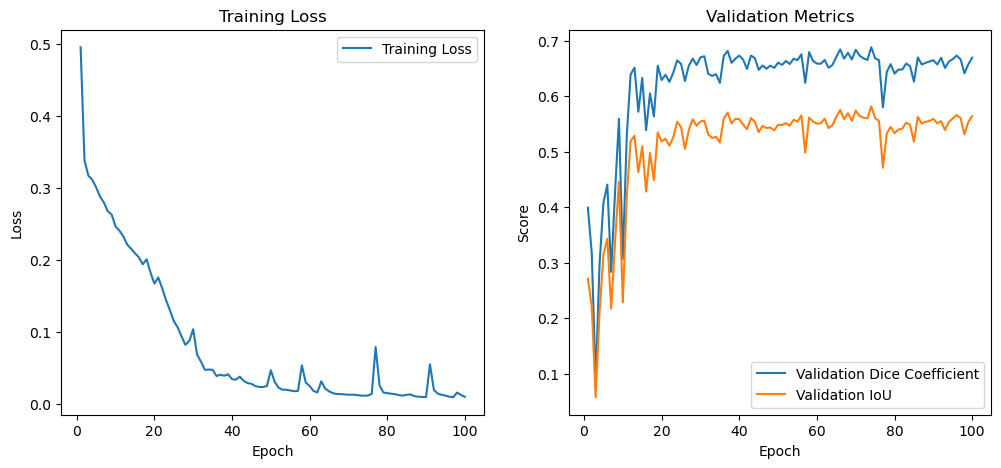

In [5]:
# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_dice_scores, label='Validation Dice Coefficient')
plt.plot(range(1, num_epochs + 1), val_ious, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Validation Metrics')

plt.show()

This structured approach ensures that the U-Net model is trained effectively for the semantic segmentation task on the Kvasir-SEG dataset, with metrics to evaluate its performance and visualizations to monitor training progress. Adjustments such as learning rate tuning or data augmentation can further optimize model performance based on specific requirements or challenges encountered during training.

# Hiper Parametes Tuning

### Finding the best batch size that fit our dataset

In [10]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def run_model(batch_sizes, num_epochs=25):
    all_results = {batch_size: {'train_losses': [], 'val_dice_scores': [], 'val_ious': []} for batch_size in batch_sizes}

    for batch_size in batch_sizes:
        print(f'Running with batch size: {batch_size}')
        
        # Initialize the model, criterion, optimizer again for each run
        model = UNet().to(device)
        model.to(device)  
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Update train_loader with the current batch_size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        train_losses = []
        val_dice_scores = []
        val_ious = []

        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
                images, masks = images.to(device), masks.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item() * images.size(0)

            epoch_loss /= len(train_loader.dataset)
            train_losses.append(epoch_loss)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

            # Validation
            model.eval()
            val_dice = 0.0
            val_iou = 0.0
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(device), masks.to(device)
                    outputs = model(images)
                    preds = outputs > 0.5
                    val_dice += dice_coefficient(preds, masks).item() * images.size(0)
                    val_iou += iou(preds, masks).item() * images.size(0)

            val_dice /= len(val_loader.dataset)
            val_iou /= len(val_loader.dataset)
            val_dice_scores.append(val_dice)
            val_ious.append(val_iou)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

        all_results[batch_size]['train_losses'] = train_losses
        all_results[batch_size]['val_dice_scores'] = val_dice_scores
        all_results[batch_size]['val_ious'] = val_iou

    return all_results



# Define batch sizes to test
batch_sizes = [4, 8, 16, 32, 64]

# Run the model with different batch sizes and plot results
all_results = run_model(batch_sizes, num_epochs=25)

Running with batch size: 4


Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:53<00:00,  1.76it/s]


Epoch [1/25], Loss: 0.5061
Epoch [1/25], Validation Dice: 0.2750, Validation IoU: 0.1802


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:53<00:00,  1.76it/s]


Epoch [2/25], Loss: 0.3333
Epoch [2/25], Validation Dice: 0.4660, Validation IoU: 0.3378


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.77it/s]


Epoch [3/25], Loss: 0.3143
Epoch [3/25], Validation Dice: 0.1574, Validation IoU: 0.1071


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:53<00:00,  1.76it/s]


Epoch [4/25], Loss: 0.3071
Epoch [4/25], Validation Dice: 0.1561, Validation IoU: 0.1084


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:53<00:00,  1.76it/s]


Epoch [5/25], Loss: 0.2979
Epoch [5/25], Validation Dice: 0.1791, Validation IoU: 0.1227


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.77it/s]


Epoch [6/25], Loss: 0.2939
Epoch [6/25], Validation Dice: 0.3752, Validation IoU: 0.2814


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [7/25], Loss: 0.2780
Epoch [7/25], Validation Dice: 0.5458, Validation IoU: 0.4216


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [8/25], Loss: 0.2656
Epoch [8/25], Validation Dice: 0.4666, Validation IoU: 0.3651


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.77it/s]


Epoch [9/25], Loss: 0.2524
Epoch [9/25], Validation Dice: 0.4447, Validation IoU: 0.3497


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:53<00:00,  1.76it/s]


Epoch [10/25], Loss: 0.2419
Epoch [10/25], Validation Dice: 0.3629, Validation IoU: 0.2761


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:53<00:00,  1.76it/s]


Epoch [11/25], Loss: 0.2319
Epoch [11/25], Validation Dice: 0.4652, Validation IoU: 0.3656


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:53<00:00,  1.76it/s]


Epoch [12/25], Loss: 0.2223
Epoch [12/25], Validation Dice: 0.5412, Validation IoU: 0.4373


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:53<00:00,  1.76it/s]


Epoch [13/25], Loss: 0.2163
Epoch [13/25], Validation Dice: 0.6500, Validation IoU: 0.5385


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.77it/s]


Epoch [14/25], Loss: 0.2079
Epoch [14/25], Validation Dice: 0.6134, Validation IoU: 0.4959


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [15/25], Loss: 0.1953
Epoch [15/25], Validation Dice: 0.6627, Validation IoU: 0.5513


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [16/25], Loss: 0.1872
Epoch [16/25], Validation Dice: 0.6930, Validation IoU: 0.5757


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [17/25], Loss: 0.1787
Epoch [17/25], Validation Dice: 0.6600, Validation IoU: 0.5500


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [18/25], Loss: 0.1653
Epoch [18/25], Validation Dice: 0.6814, Validation IoU: 0.5730


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.77it/s]


Epoch [19/25], Loss: 0.1617
Epoch [19/25], Validation Dice: 0.6926, Validation IoU: 0.5832


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [20/25], Loss: 0.1483
Epoch [20/25], Validation Dice: 0.6740, Validation IoU: 0.5686


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [21/25], Loss: 0.1335
Epoch [21/25], Validation Dice: 0.7114, Validation IoU: 0.6003


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:53<00:00,  1.76it/s]


Epoch [22/25], Loss: 0.1190
Epoch [22/25], Validation Dice: 0.6739, Validation IoU: 0.5660


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [23/25], Loss: 0.1108
Epoch [23/25], Validation Dice: 0.6853, Validation IoU: 0.5723


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [24/25], Loss: 0.0981
Epoch [24/25], Validation Dice: 0.6986, Validation IoU: 0.5888


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:53<00:00,  1.77it/s]


Epoch [25/25], Loss: 0.0827
Epoch [25/25], Validation Dice: 0.6990, Validation IoU: 0.5883
Running with batch size: 8


Epoch 1/25: 100%|█████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


Epoch [1/25], Loss: 0.5459
Epoch [1/25], Validation Dice: 0.2501, Validation IoU: 0.1626


Epoch 2/25: 100%|█████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


Epoch [2/25], Loss: 0.3820
Epoch [2/25], Validation Dice: 0.3317, Validation IoU: 0.2297


Epoch 3/25: 100%|█████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


Epoch [3/25], Loss: 0.3203
Epoch [3/25], Validation Dice: 0.3845, Validation IoU: 0.2775


Epoch 4/25: 100%|█████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


Epoch [4/25], Loss: 0.2987
Epoch [4/25], Validation Dice: 0.5001, Validation IoU: 0.3740


Epoch 5/25: 100%|█████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


Epoch [5/25], Loss: 0.2847
Epoch [5/25], Validation Dice: 0.4727, Validation IoU: 0.3618


Epoch 6/25: 100%|█████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


Epoch [6/25], Loss: 0.2727
Epoch [6/25], Validation Dice: 0.2951, Validation IoU: 0.2173


Epoch 7/25: 100%|█████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


Epoch [7/25], Loss: 0.2615
Epoch [7/25], Validation Dice: 0.5640, Validation IoU: 0.4411


Epoch 8/25: 100%|█████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


Epoch [8/25], Loss: 0.2484
Epoch [8/25], Validation Dice: 0.4874, Validation IoU: 0.3865


Epoch 9/25: 100%|█████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


Epoch [9/25], Loss: 0.2354
Epoch [9/25], Validation Dice: 0.5457, Validation IoU: 0.4310


Epoch 10/25: 100%|████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


Epoch [10/25], Loss: 0.2257
Epoch [10/25], Validation Dice: 0.5994, Validation IoU: 0.4834


Epoch 11/25: 100%|████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


Epoch [11/25], Loss: 0.2123
Epoch [11/25], Validation Dice: 0.5553, Validation IoU: 0.4486


Epoch 12/25: 100%|████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


Epoch [12/25], Loss: 0.2141
Epoch [12/25], Validation Dice: 0.6065, Validation IoU: 0.4958


Epoch 13/25: 100%|████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


Epoch [13/25], Loss: 0.1946
Epoch [13/25], Validation Dice: 0.6169, Validation IoU: 0.5075


Epoch 14/25: 100%|████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


Epoch [14/25], Loss: 0.1872
Epoch [14/25], Validation Dice: 0.4043, Validation IoU: 0.3154


Epoch 15/25: 100%|████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


Epoch [15/25], Loss: 0.1835
Epoch [15/25], Validation Dice: 0.5326, Validation IoU: 0.4270


Epoch 16/25: 100%|████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


Epoch [16/25], Loss: 0.1677
Epoch [16/25], Validation Dice: 0.6736, Validation IoU: 0.5684


Epoch 17/25: 100%|████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


Epoch [17/25], Loss: 0.1525
Epoch [17/25], Validation Dice: 0.6516, Validation IoU: 0.5483


Epoch 18/25: 100%|████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


Epoch [18/25], Loss: 0.1411
Epoch [18/25], Validation Dice: 0.6984, Validation IoU: 0.5839


Epoch 19/25: 100%|████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


Epoch [19/25], Loss: 0.1290
Epoch [19/25], Validation Dice: 0.6341, Validation IoU: 0.5252


Epoch 20/25: 100%|████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


Epoch [20/25], Loss: 0.1202
Epoch [20/25], Validation Dice: 0.6133, Validation IoU: 0.5042


Epoch 21/25: 100%|████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


Epoch [21/25], Loss: 0.1025
Epoch [21/25], Validation Dice: 0.7061, Validation IoU: 0.6007


Epoch 22/25: 100%|████████████████████████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [22/25], Loss: 0.0935
Epoch [22/25], Validation Dice: 0.7074, Validation IoU: 0.6018


Epoch 23/25: 100%|████████████████████████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [23/25], Loss: 0.0774
Epoch [23/25], Validation Dice: 0.6778, Validation IoU: 0.5559


Epoch 24/25: 100%|████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


Epoch [24/25], Loss: 0.0766
Epoch [24/25], Validation Dice: 0.7179, Validation IoU: 0.6076


Epoch 25/25: 100%|████████████████████████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [25/25], Loss: 0.0635
Epoch [25/25], Validation Dice: 0.7104, Validation IoU: 0.6025
Running with batch size: 16


Epoch 1/25: 100%|███████████████████████████████| 50/50 [01:54<00:00,  2.30s/it]


Epoch [1/25], Loss: 0.6168
Epoch [1/25], Validation Dice: 0.4037, Validation IoU: 0.2808


Epoch 2/25: 100%|███████████████████████████████| 50/50 [01:54<00:00,  2.29s/it]


Epoch [2/25], Loss: 0.5126
Epoch [2/25], Validation Dice: 0.4243, Validation IoU: 0.2982


Epoch 3/25: 100%|███████████████████████████████| 50/50 [01:54<00:00,  2.29s/it]


Epoch [3/25], Loss: 0.3971
Epoch [3/25], Validation Dice: 0.3825, Validation IoU: 0.2775


Epoch 4/25: 100%|███████████████████████████████| 50/50 [01:54<00:00,  2.28s/it]


Epoch [4/25], Loss: 0.3306
Epoch [4/25], Validation Dice: 0.3943, Validation IoU: 0.2895


Epoch 5/25: 100%|███████████████████████████████| 50/50 [01:54<00:00,  2.29s/it]


Epoch [5/25], Loss: 0.3056
Epoch [5/25], Validation Dice: 0.4274, Validation IoU: 0.3099


Epoch 6/25: 100%|███████████████████████████████| 50/50 [01:54<00:00,  2.29s/it]


Epoch [6/25], Loss: 0.2923
Epoch [6/25], Validation Dice: 0.5094, Validation IoU: 0.3754


Epoch 7/25: 100%|███████████████████████████████| 50/50 [01:54<00:00,  2.29s/it]


Epoch [7/25], Loss: 0.2825
Epoch [7/25], Validation Dice: 0.4395, Validation IoU: 0.3359


Epoch 8/25: 100%|███████████████████████████████| 50/50 [01:53<00:00,  2.28s/it]


Epoch [8/25], Loss: 0.2704
Epoch [8/25], Validation Dice: 0.2859, Validation IoU: 0.2132


Epoch 9/25: 100%|███████████████████████████████| 50/50 [01:54<00:00,  2.29s/it]


Epoch [9/25], Loss: 0.2639
Epoch [9/25], Validation Dice: 0.4816, Validation IoU: 0.3665


Epoch 10/25: 100%|██████████████████████████████| 50/50 [01:53<00:00,  2.28s/it]


Epoch [10/25], Loss: 0.2573
Epoch [10/25], Validation Dice: 0.5648, Validation IoU: 0.4488


Epoch 11/25: 100%|██████████████████████████████| 50/50 [01:54<00:00,  2.28s/it]


Epoch [11/25], Loss: 0.2388
Epoch [11/25], Validation Dice: 0.5384, Validation IoU: 0.4144


Epoch 12/25: 100%|██████████████████████████████| 50/50 [01:52<00:00,  2.26s/it]


Epoch [12/25], Loss: 0.2356
Epoch [12/25], Validation Dice: 0.5800, Validation IoU: 0.4667


Epoch 13/25: 100%|██████████████████████████████| 50/50 [01:52<00:00,  2.26s/it]


Epoch [13/25], Loss: 0.2192
Epoch [13/25], Validation Dice: 0.5455, Validation IoU: 0.4399


Epoch 14/25: 100%|██████████████████████████████| 50/50 [01:52<00:00,  2.26s/it]


Epoch [14/25], Loss: 0.2106
Epoch [14/25], Validation Dice: 0.6382, Validation IoU: 0.5139


Epoch 15/25: 100%|██████████████████████████████| 50/50 [01:53<00:00,  2.27s/it]


Epoch [15/25], Loss: 0.1908
Epoch [15/25], Validation Dice: 0.6375, Validation IoU: 0.5284


Epoch 16/25: 100%|██████████████████████████████| 50/50 [01:53<00:00,  2.28s/it]


Epoch [16/25], Loss: 0.1885
Epoch [16/25], Validation Dice: 0.6295, Validation IoU: 0.5175


Epoch 17/25: 100%|██████████████████████████████| 50/50 [01:54<00:00,  2.29s/it]


Epoch [17/25], Loss: 0.1773
Epoch [17/25], Validation Dice: 0.6396, Validation IoU: 0.5285


Epoch 18/25: 100%|██████████████████████████████| 50/50 [01:53<00:00,  2.27s/it]


Epoch [18/25], Loss: 0.1570
Epoch [18/25], Validation Dice: 0.5671, Validation IoU: 0.4654


Epoch 19/25: 100%|██████████████████████████████| 50/50 [01:55<00:00,  2.31s/it]


Epoch [19/25], Loss: 0.1463
Epoch [19/25], Validation Dice: 0.6795, Validation IoU: 0.5660


Epoch 20/25: 100%|██████████████████████████████| 50/50 [01:54<00:00,  2.28s/it]


Epoch [20/25], Loss: 0.1403
Epoch [20/25], Validation Dice: 0.6886, Validation IoU: 0.5712


Epoch 21/25: 100%|██████████████████████████████| 50/50 [01:54<00:00,  2.30s/it]


Epoch [21/25], Loss: 0.1261
Epoch [21/25], Validation Dice: 0.6834, Validation IoU: 0.5693


Epoch 22/25: 100%|██████████████████████████████| 50/50 [01:55<00:00,  2.30s/it]


Epoch [22/25], Loss: 0.1275
Epoch [22/25], Validation Dice: 0.6566, Validation IoU: 0.5490


Epoch 23/25: 100%|██████████████████████████████| 50/50 [01:54<00:00,  2.29s/it]


Epoch [23/25], Loss: 0.1068
Epoch [23/25], Validation Dice: 0.7118, Validation IoU: 0.5985


Epoch 24/25: 100%|██████████████████████████████| 50/50 [01:55<00:00,  2.30s/it]


Epoch [24/25], Loss: 0.0882
Epoch [24/25], Validation Dice: 0.6964, Validation IoU: 0.5835


Epoch 25/25: 100%|██████████████████████████████| 50/50 [01:56<00:00,  2.32s/it]


Epoch [25/25], Loss: 0.0775
Epoch [25/25], Validation Dice: 0.7187, Validation IoU: 0.6105
Running with batch size: 32


Epoch 1/25: 100%|███████████████████████████████| 25/25 [02:00<00:00,  4.81s/it]


Epoch [1/25], Loss: 0.6800
Epoch [1/25], Validation Dice: 0.0951, Validation IoU: 0.0629


Epoch 2/25: 100%|███████████████████████████████| 25/25 [01:58<00:00,  4.75s/it]


Epoch [2/25], Loss: 0.6180
Epoch [2/25], Validation Dice: 0.4353, Validation IoU: 0.3033


Epoch 3/25: 100%|███████████████████████████████| 25/25 [01:58<00:00,  4.74s/it]


Epoch [3/25], Loss: 0.5504
Epoch [3/25], Validation Dice: 0.3372, Validation IoU: 0.2249


Epoch 4/25: 100%|███████████████████████████████| 25/25 [01:57<00:00,  4.69s/it]


Epoch [4/25], Loss: 0.4832
Epoch [4/25], Validation Dice: 0.4688, Validation IoU: 0.3341


Epoch 5/25: 100%|███████████████████████████████| 25/25 [01:57<00:00,  4.69s/it]


Epoch [5/25], Loss: 0.4106
Epoch [5/25], Validation Dice: 0.5055, Validation IoU: 0.3705


Epoch 6/25: 100%|███████████████████████████████| 25/25 [01:57<00:00,  4.69s/it]


Epoch [6/25], Loss: 0.3559
Epoch [6/25], Validation Dice: 0.5047, Validation IoU: 0.3799


Epoch 7/25: 100%|███████████████████████████████| 25/25 [01:57<00:00,  4.69s/it]


Epoch [7/25], Loss: 0.3196
Epoch [7/25], Validation Dice: 0.2228, Validation IoU: 0.1524


Epoch 8/25: 100%|███████████████████████████████| 25/25 [01:57<00:00,  4.69s/it]


Epoch [8/25], Loss: 0.3003
Epoch [8/25], Validation Dice: 0.3382, Validation IoU: 0.2426


Epoch 9/25: 100%|███████████████████████████████| 25/25 [01:56<00:00,  4.68s/it]


Epoch [9/25], Loss: 0.2797
Epoch [9/25], Validation Dice: 0.1630, Validation IoU: 0.1139


Epoch 10/25: 100%|██████████████████████████████| 25/25 [01:57<00:00,  4.69s/it]


Epoch [10/25], Loss: 0.2734
Epoch [10/25], Validation Dice: 0.0579, Validation IoU: 0.0395


Epoch 11/25: 100%|██████████████████████████████| 25/25 [01:57<00:00,  4.69s/it]


Epoch [11/25], Loss: 0.2654
Epoch [11/25], Validation Dice: 0.4983, Validation IoU: 0.3805


Epoch 12/25: 100%|██████████████████████████████| 25/25 [01:58<00:00,  4.74s/it]


Epoch [12/25], Loss: 0.2474
Epoch [12/25], Validation Dice: 0.4186, Validation IoU: 0.3049


Epoch 13/25: 100%|██████████████████████████████| 25/25 [01:58<00:00,  4.73s/it]


Epoch [13/25], Loss: 0.2365
Epoch [13/25], Validation Dice: 0.3782, Validation IoU: 0.2842


Epoch 14/25: 100%|██████████████████████████████| 25/25 [01:57<00:00,  4.69s/it]


Epoch [14/25], Loss: 0.2221
Epoch [14/25], Validation Dice: 0.5946, Validation IoU: 0.4686


Epoch 15/25: 100%|██████████████████████████████| 25/25 [01:57<00:00,  4.71s/it]


Epoch [15/25], Loss: 0.2116
Epoch [15/25], Validation Dice: 0.2901, Validation IoU: 0.2264


Epoch 16/25: 100%|██████████████████████████████| 25/25 [01:58<00:00,  4.72s/it]


Epoch [16/25], Loss: 0.2066
Epoch [16/25], Validation Dice: 0.3523, Validation IoU: 0.2738


Epoch 17/25: 100%|██████████████████████████████| 25/25 [01:59<00:00,  4.77s/it]


Epoch [17/25], Loss: 0.1923
Epoch [17/25], Validation Dice: 0.5613, Validation IoU: 0.4514


Epoch 18/25: 100%|██████████████████████████████| 25/25 [01:57<00:00,  4.71s/it]


Epoch [18/25], Loss: 0.1900
Epoch [18/25], Validation Dice: 0.3040, Validation IoU: 0.2323


Epoch 19/25: 100%|██████████████████████████████| 25/25 [01:56<00:00,  4.64s/it]


Epoch [19/25], Loss: 0.1652
Epoch [19/25], Validation Dice: 0.5575, Validation IoU: 0.4408


Epoch 20/25: 100%|██████████████████████████████| 25/25 [01:56<00:00,  4.65s/it]


Epoch [20/25], Loss: 0.1600
Epoch [20/25], Validation Dice: 0.5944, Validation IoU: 0.4800


Epoch 21/25: 100%|██████████████████████████████| 25/25 [01:58<00:00,  4.75s/it]


Epoch [21/25], Loss: 0.1513
Epoch [21/25], Validation Dice: 0.5909, Validation IoU: 0.4772


Epoch 22/25: 100%|██████████████████████████████| 25/25 [01:58<00:00,  4.74s/it]


Epoch [22/25], Loss: 0.1327
Epoch [22/25], Validation Dice: 0.6271, Validation IoU: 0.5200


Epoch 23/25: 100%|██████████████████████████████| 25/25 [01:57<00:00,  4.68s/it]


Epoch [23/25], Loss: 0.1186
Epoch [23/25], Validation Dice: 0.5095, Validation IoU: 0.4164


Epoch 24/25: 100%|██████████████████████████████| 25/25 [01:58<00:00,  4.72s/it]


Epoch [24/25], Loss: 0.1075
Epoch [24/25], Validation Dice: 0.5560, Validation IoU: 0.4576


Epoch 25/25: 100%|██████████████████████████████| 25/25 [01:58<00:00,  4.73s/it]


Epoch [25/25], Loss: 0.1005
Epoch [25/25], Validation Dice: 0.7019, Validation IoU: 0.6004
Running with batch size: 64


Epoch 1/25: 100%|███████████████████████████████| 13/13 [02:47<00:00, 12.90s/it]


Epoch [1/25], Loss: 0.6365
Epoch [1/25], Validation Dice: 0.0409, Validation IoU: 0.0225


Epoch 2/25: 100%|███████████████████████████████| 13/13 [02:44<00:00, 12.68s/it]


Epoch [2/25], Loss: 0.5961
Epoch [2/25], Validation Dice: 0.2806, Validation IoU: 0.1764


Epoch 3/25: 100%|███████████████████████████████| 13/13 [02:40<00:00, 12.38s/it]


Epoch [3/25], Loss: 0.5744
Epoch [3/25], Validation Dice: 0.3990, Validation IoU: 0.2781


Epoch 4/25: 100%|███████████████████████████████| 13/13 [02:38<00:00, 12.16s/it]


Epoch [4/25], Loss: 0.5490
Epoch [4/25], Validation Dice: 0.0125, Validation IoU: 0.0070


Epoch 5/25: 100%|███████████████████████████████| 13/13 [02:42<00:00, 12.53s/it]


Epoch [5/25], Loss: 0.5266
Epoch [5/25], Validation Dice: 0.2263, Validation IoU: 0.1437


Epoch 6/25: 100%|███████████████████████████████| 13/13 [02:35<00:00, 11.93s/it]


Epoch [6/25], Loss: 0.4918
Epoch [6/25], Validation Dice: 0.3126, Validation IoU: 0.2011


Epoch 7/25: 100%|███████████████████████████████| 13/13 [02:35<00:00, 11.99s/it]


Epoch [7/25], Loss: 0.4602
Epoch [7/25], Validation Dice: 0.4516, Validation IoU: 0.3198


Epoch 8/25: 100%|███████████████████████████████| 13/13 [02:32<00:00, 11.69s/it]


Epoch [8/25], Loss: 0.4254
Epoch [8/25], Validation Dice: 0.2710, Validation IoU: 0.1834


Epoch 9/25: 100%|███████████████████████████████| 13/13 [02:34<00:00, 11.89s/it]


Epoch [9/25], Loss: 0.3952
Epoch [9/25], Validation Dice: 0.3085, Validation IoU: 0.2029


Epoch 10/25: 100%|██████████████████████████████| 13/13 [02:36<00:00, 12.04s/it]


Epoch [10/25], Loss: 0.3724
Epoch [10/25], Validation Dice: 0.3559, Validation IoU: 0.2442


Epoch 11/25: 100%|██████████████████████████████| 13/13 [02:37<00:00, 12.13s/it]


Epoch [11/25], Loss: 0.3546
Epoch [11/25], Validation Dice: 0.3851, Validation IoU: 0.2721


Epoch 12/25: 100%|██████████████████████████████| 13/13 [02:34<00:00, 11.85s/it]


Epoch [12/25], Loss: 0.3330
Epoch [12/25], Validation Dice: 0.0440, Validation IoU: 0.0264


Epoch 13/25: 100%|██████████████████████████████| 13/13 [02:33<00:00, 11.78s/it]


Epoch [13/25], Loss: 0.3175
Epoch [13/25], Validation Dice: 0.4456, Validation IoU: 0.3267


Epoch 14/25: 100%|██████████████████████████████| 13/13 [02:41<00:00, 12.42s/it]


Epoch [14/25], Loss: 0.3107
Epoch [14/25], Validation Dice: 0.4407, Validation IoU: 0.3226


Epoch 15/25: 100%|██████████████████████████████| 13/13 [02:41<00:00, 12.45s/it]


Epoch [15/25], Loss: 0.3074
Epoch [15/25], Validation Dice: 0.4191, Validation IoU: 0.3024


Epoch 16/25: 100%|██████████████████████████████| 13/13 [02:39<00:00, 12.24s/it]


Epoch [16/25], Loss: 0.2994
Epoch [16/25], Validation Dice: 0.2447, Validation IoU: 0.1692


Epoch 17/25: 100%|██████████████████████████████| 13/13 [02:35<00:00, 11.99s/it]


Epoch [17/25], Loss: 0.2951
Epoch [17/25], Validation Dice: 0.4605, Validation IoU: 0.3435


Epoch 18/25: 100%|██████████████████████████████| 13/13 [02:25<00:00, 11.21s/it]


Epoch [18/25], Loss: 0.2840
Epoch [18/25], Validation Dice: 0.4571, Validation IoU: 0.3419


Epoch 19/25: 100%|██████████████████████████████| 13/13 [02:39<00:00, 12.30s/it]


Epoch [19/25], Loss: 0.2828
Epoch [19/25], Validation Dice: 0.3655, Validation IoU: 0.2612


Epoch 20/25: 100%|██████████████████████████████| 13/13 [02:40<00:00, 12.36s/it]


Epoch [20/25], Loss: 0.2775
Epoch [20/25], Validation Dice: 0.4838, Validation IoU: 0.3599


Epoch 21/25: 100%|██████████████████████████████| 13/13 [02:33<00:00, 11.81s/it]


Epoch [21/25], Loss: 0.2792
Epoch [21/25], Validation Dice: 0.2586, Validation IoU: 0.1859


Epoch 22/25: 100%|██████████████████████████████| 13/13 [02:31<00:00, 11.68s/it]


Epoch [22/25], Loss: 0.2661
Epoch [22/25], Validation Dice: 0.3419, Validation IoU: 0.2522


Epoch 23/25: 100%|██████████████████████████████| 13/13 [02:33<00:00, 11.80s/it]


Epoch [23/25], Loss: 0.2540
Epoch [23/25], Validation Dice: 0.4391, Validation IoU: 0.3315


Epoch 24/25: 100%|██████████████████████████████| 13/13 [02:28<00:00, 11.43s/it]


Epoch [24/25], Loss: 0.2551
Epoch [24/25], Validation Dice: 0.0304, Validation IoU: 0.0196


Epoch 25/25: 100%|██████████████████████████████| 13/13 [02:26<00:00, 11.30s/it]


Epoch [25/25], Loss: 0.2475
Epoch [25/25], Validation Dice: 0.2701, Validation IoU: 0.1954


In [11]:
# Plotting batch size check resutls

In [51]:
def plot_results(all_results, num_epochs):
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(15, 20))

    # Plot training losses
    plt.subplot(3, 1, 1)
    for batch_size, results in all_results.items():
        plt.plot(epochs, results['train_losses'], label=f'Batch size {batch_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot validation Dice scores
    plt.subplot(3, 1, 2)
    for batch_size, results in all_results.items():
        plt.plot(epochs, results['val_dice_scores'], label=f'Batch size {batch_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Dice Score')
    plt.title('Validation Dice Score Over Epochs')
    plt.legend()
    

    # Plot validation IoU scores
    plt.subplot(3, 1, 3)
    for batch_size, results in all_results.items():
        plt.plot(epochs, results['val_ious'], label=f'Batch size {batch_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation IoU')
    plt.title('Validation IoU Over Epochs')
    plt.legend()

    
    plt.tight_layout()
    plt.show()

In [52]:
for batch_size, results in all_results.items():
    print(results['val_ious'])

0.5882835656404495
0.6024853706359863
0.6104707956314087
0.6004379653930664
0.19544978559017182


ValueError: x and y must have same first dimension, but have shapes (25,) and (1,)

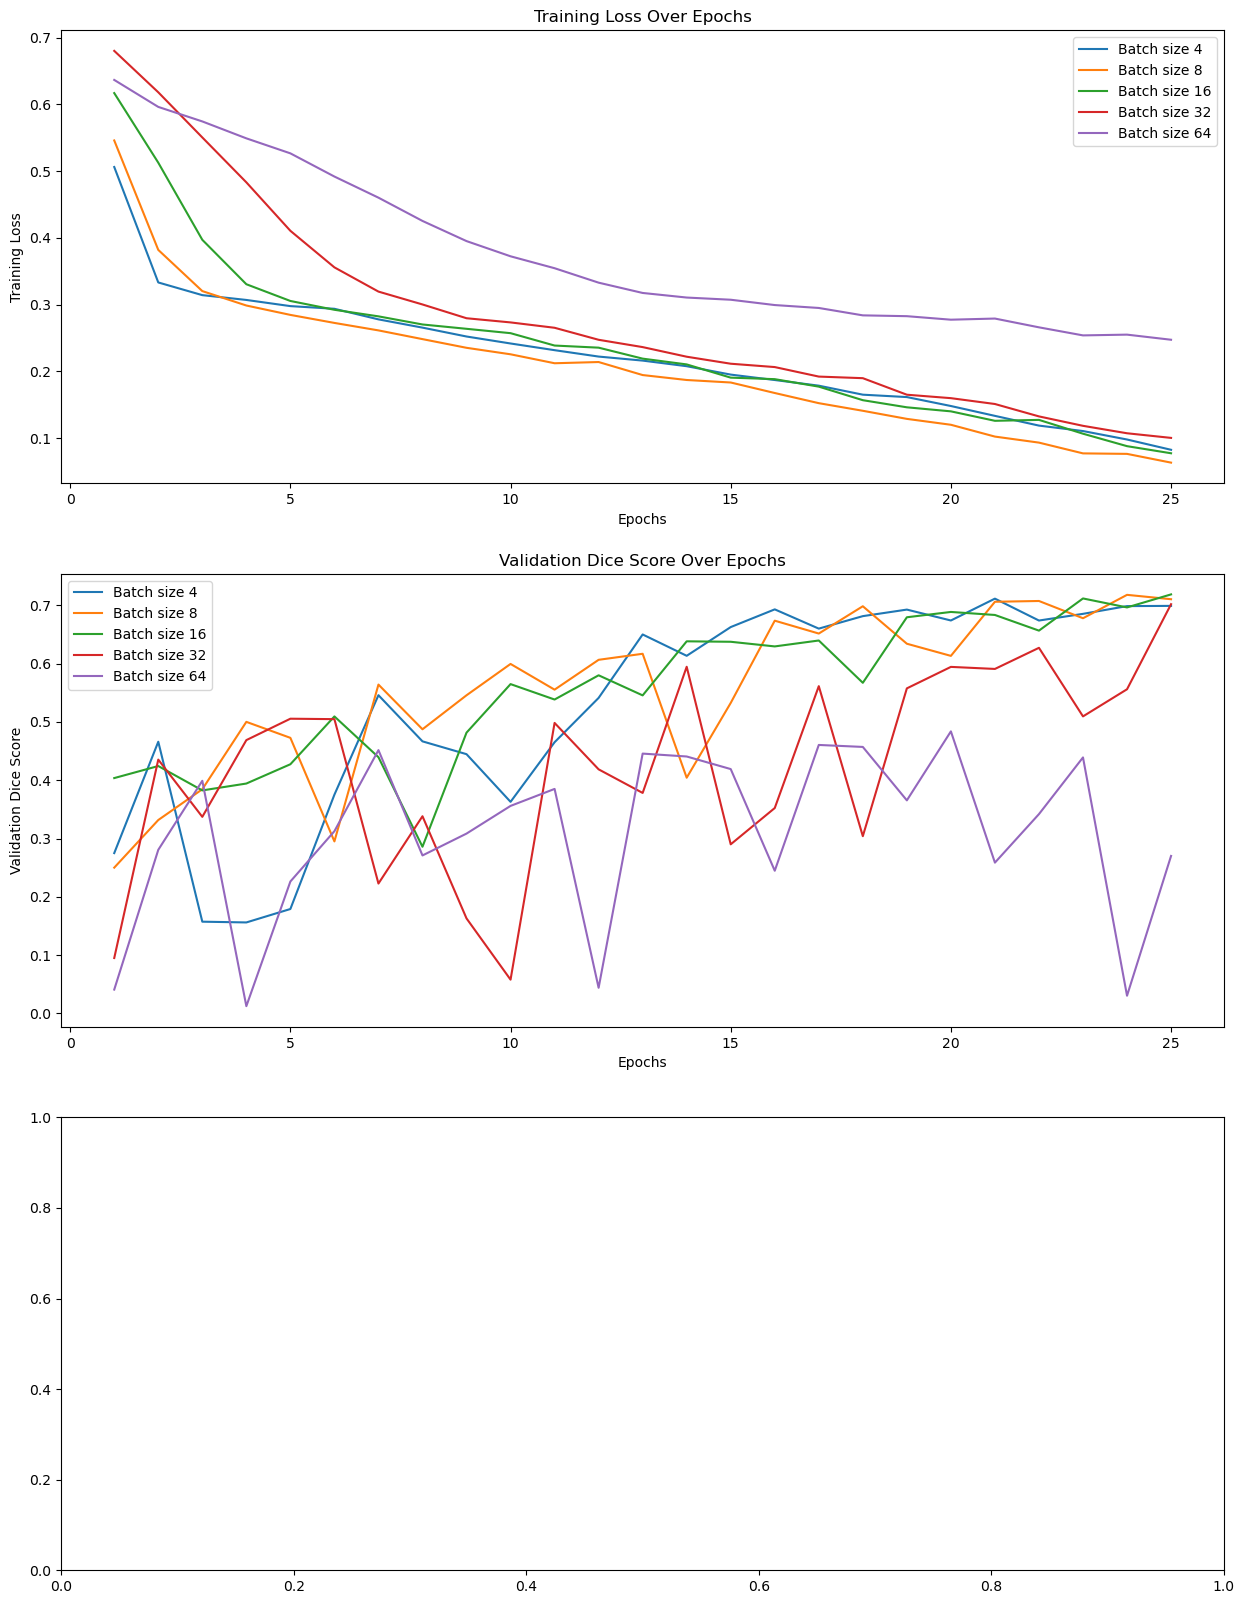

In [53]:
plot_results(all_results, num_epochs=25)

### Finding the best Loss Function to optimize our results

Running with loss function: BCELoss


Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:53<00:00,  1.77it/s]


Epoch [1/25], Loss: 0.4808
Epoch [1/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [2/25], Loss: 0.3440
Epoch [2/25], Validation Dice: 0.1073, Validation IoU: 0.0675


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [3/25], Loss: 0.3234
Epoch [3/25], Validation Dice: 0.2593, Validation IoU: 0.1772


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [4/25], Loss: 0.3189
Epoch [4/25], Validation Dice: 0.1478, Validation IoU: 0.0968


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [5/25], Loss: 0.3146
Epoch [5/25], Validation Dice: 0.4782, Validation IoU: 0.3455


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [6/25], Loss: 0.3099
Epoch [6/25], Validation Dice: 0.3421, Validation IoU: 0.2464


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [7/25], Loss: 0.3011
Epoch [7/25], Validation Dice: 0.2603, Validation IoU: 0.1901


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [8/25], Loss: 0.2985
Epoch [8/25], Validation Dice: 0.3454, Validation IoU: 0.2595


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [9/25], Loss: 0.2920
Epoch [9/25], Validation Dice: 0.1312, Validation IoU: 0.0939


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [10/25], Loss: 0.2854
Epoch [10/25], Validation Dice: 0.3073, Validation IoU: 0.2388


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [11/25], Loss: 0.2847
Epoch [11/25], Validation Dice: 0.2708, Validation IoU: 0.1966


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [12/25], Loss: 0.2830
Epoch [12/25], Validation Dice: 0.3970, Validation IoU: 0.3064


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [13/25], Loss: 0.2731
Epoch [13/25], Validation Dice: 0.4994, Validation IoU: 0.3915


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [14/25], Loss: 0.2704
Epoch [14/25], Validation Dice: 0.4154, Validation IoU: 0.3223


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [15/25], Loss: 0.2753
Epoch [15/25], Validation Dice: 0.4807, Validation IoU: 0.3723


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [16/25], Loss: 0.2565
Epoch [16/25], Validation Dice: 0.4359, Validation IoU: 0.3408


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [17/25], Loss: 0.2501
Epoch [17/25], Validation Dice: 0.5708, Validation IoU: 0.4533


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [18/25], Loss: 0.2440
Epoch [18/25], Validation Dice: 0.5840, Validation IoU: 0.4665


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [19/25], Loss: 0.2386
Epoch [19/25], Validation Dice: 0.5551, Validation IoU: 0.4484


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [20/25], Loss: 0.2304
Epoch [20/25], Validation Dice: 0.5450, Validation IoU: 0.4378


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [21/25], Loss: 0.2242
Epoch [21/25], Validation Dice: 0.5346, Validation IoU: 0.4339


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [22/25], Loss: 0.2156
Epoch [22/25], Validation Dice: 0.6423, Validation IoU: 0.5275


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [23/25], Loss: 0.2158
Epoch [23/25], Validation Dice: 0.5842, Validation IoU: 0.4737


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [24/25], Loss: 0.2123
Epoch [24/25], Validation Dice: 0.6293, Validation IoU: 0.5007


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [25/25], Loss: 0.2339
Epoch [25/25], Validation Dice: 0.4821, Validation IoU: 0.3694
Running with loss function: DiceLoss


Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [1/25], Loss: 0.5935
Epoch [1/25], Validation Dice: 0.3993, Validation IoU: 0.2780


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [2/25], Loss: 0.5688
Epoch [2/25], Validation Dice: 0.4291, Validation IoU: 0.3062


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [3/25], Loss: 0.5342
Epoch [3/25], Validation Dice: 0.4396, Validation IoU: 0.3187


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [4/25], Loss: 0.5040
Epoch [4/25], Validation Dice: 0.4726, Validation IoU: 0.3502


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [5/25], Loss: 0.4885
Epoch [5/25], Validation Dice: 0.4817, Validation IoU: 0.3587


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [6/25], Loss: 0.4704
Epoch [6/25], Validation Dice: 0.5040, Validation IoU: 0.3800


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [7/25], Loss: 0.4548
Epoch [7/25], Validation Dice: 0.4935, Validation IoU: 0.3748


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [8/25], Loss: 0.4485
Epoch [8/25], Validation Dice: 0.5070, Validation IoU: 0.3824


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [9/25], Loss: 0.4326
Epoch [9/25], Validation Dice: 0.5137, Validation IoU: 0.3885


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [10/25], Loss: 0.4202
Epoch [10/25], Validation Dice: 0.5188, Validation IoU: 0.4052


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [11/25], Loss: 0.4312
Epoch [11/25], Validation Dice: 0.4358, Validation IoU: 0.3351


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [12/25], Loss: 0.4117
Epoch [12/25], Validation Dice: 0.5412, Validation IoU: 0.4181


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [13/25], Loss: 0.4190
Epoch [13/25], Validation Dice: 0.5436, Validation IoU: 0.4271


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [14/25], Loss: 0.4070
Epoch [14/25], Validation Dice: 0.5386, Validation IoU: 0.4219


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [15/25], Loss: 0.3964
Epoch [15/25], Validation Dice: 0.5454, Validation IoU: 0.4331


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [16/25], Loss: 0.3798
Epoch [16/25], Validation Dice: 0.5652, Validation IoU: 0.4482


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [17/25], Loss: 0.3731
Epoch [17/25], Validation Dice: 0.5645, Validation IoU: 0.4459


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [18/25], Loss: 0.3618
Epoch [18/25], Validation Dice: 0.5543, Validation IoU: 0.4414


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [19/25], Loss: 0.3856
Epoch [19/25], Validation Dice: 0.5319, Validation IoU: 0.4066


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [20/25], Loss: 0.3722
Epoch [20/25], Validation Dice: 0.5670, Validation IoU: 0.4560


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [21/25], Loss: 0.3521
Epoch [21/25], Validation Dice: 0.5880, Validation IoU: 0.4749


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [22/25], Loss: 0.3444
Epoch [22/25], Validation Dice: 0.5682, Validation IoU: 0.4602


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [23/25], Loss: 0.3421
Epoch [23/25], Validation Dice: 0.5545, Validation IoU: 0.4434


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [24/25], Loss: 0.3336
Epoch [24/25], Validation Dice: 0.6042, Validation IoU: 0.4924


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [25/25], Loss: 0.3234
Epoch [25/25], Validation Dice: 0.5974, Validation IoU: 0.4849
Running with loss function: BCEWithLogitsLoss


Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [1/25], Loss: 0.7440
Epoch [1/25], Validation Dice: 0.4053, Validation IoU: 0.2848


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [2/25], Loss: 0.7029
Epoch [2/25], Validation Dice: 0.0256, Validation IoU: 0.0142


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [3/25], Loss: 0.6958
Epoch [3/25], Validation Dice: 0.0592, Validation IoU: 0.0365


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [4/25], Loss: 0.6928
Epoch [4/25], Validation Dice: 0.2442, Validation IoU: 0.1636


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [5/25], Loss: 0.6927
Epoch [5/25], Validation Dice: 0.2472, Validation IoU: 0.1674


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [6/25], Loss: 0.6922
Epoch [6/25], Validation Dice: 0.1025, Validation IoU: 0.0653


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [7/25], Loss: 0.6918
Epoch [7/25], Validation Dice: 0.0606, Validation IoU: 0.0360


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [8/25], Loss: 0.6919
Epoch [8/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [9/25], Loss: 0.6933
Epoch [9/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [10/25], Loss: 0.6933
Epoch [10/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [11/25], Loss: 0.6932
Epoch [11/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [12/25], Loss: 0.6932
Epoch [12/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [13/25], Loss: 0.6932
Epoch [13/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [14/25], Loss: 0.6932
Epoch [14/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [15/25], Loss: 0.6932
Epoch [15/25], Validation Dice: 0.2596, Validation IoU: 0.1625


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [16/25], Loss: 0.6932
Epoch [16/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [17/25], Loss: 0.6932
Epoch [17/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [18/25], Loss: 0.6932
Epoch [18/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [19/25], Loss: 0.6932
Epoch [19/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [20/25], Loss: 0.6932
Epoch [20/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [21/25], Loss: 0.6932
Epoch [21/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [22/25], Loss: 0.6932
Epoch [22/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [23/25], Loss: 0.6932
Epoch [23/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [24/25], Loss: 0.6932
Epoch [24/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [25/25], Loss: 0.6932
Epoch [25/25], Validation Dice: 0.0000, Validation IoU: 0.0000
Running with loss function: FocalLoss


Epoch 1/25:   0%|                                       | 0/200 [00:00<?, ?it/s]/Users/snirtahasa/anaconda3/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [1/25], Loss: 0.1132
Epoch [1/25], Validation Dice: 0.0867, Validation IoU: 0.0505


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [2/25], Loss: 0.0991
Epoch [2/25], Validation Dice: 0.0778, Validation IoU: 0.0476


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [3/25], Loss: 0.0975
Epoch [3/25], Validation Dice: 0.3157, Validation IoU: 0.2198


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [4/25], Loss: 0.0999
Epoch [4/25], Validation Dice: 0.1227, Validation IoU: 0.0797


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [5/25], Loss: 0.0949
Epoch [5/25], Validation Dice: 0.2975, Validation IoU: 0.2107


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [6/25], Loss: 0.0959
Epoch [6/25], Validation Dice: 0.2858, Validation IoU: 0.2027


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [7/25], Loss: 0.0917
Epoch [7/25], Validation Dice: 0.2291, Validation IoU: 0.1639


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [8/25], Loss: 0.0894
Epoch [8/25], Validation Dice: 0.5063, Validation IoU: 0.3849


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [9/25], Loss: 0.0852
Epoch [9/25], Validation Dice: 0.5540, Validation IoU: 0.4207


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [10/25], Loss: 0.0826
Epoch [10/25], Validation Dice: 0.2687, Validation IoU: 0.1932


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [11/25], Loss: 0.0824
Epoch [11/25], Validation Dice: 0.5625, Validation IoU: 0.4466


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [12/25], Loss: 0.0799
Epoch [12/25], Validation Dice: 0.0191, Validation IoU: 0.0120


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [13/25], Loss: 0.0781
Epoch [13/25], Validation Dice: 0.5674, Validation IoU: 0.4530


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [14/25], Loss: 0.0727
Epoch [14/25], Validation Dice: 0.6065, Validation IoU: 0.4868


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [15/25], Loss: 0.0734
Epoch [15/25], Validation Dice: 0.6293, Validation IoU: 0.5069


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [16/25], Loss: 0.0695
Epoch [16/25], Validation Dice: 0.6401, Validation IoU: 0.5114


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [17/25], Loss: 0.0677
Epoch [17/25], Validation Dice: 0.4072, Validation IoU: 0.3208


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [18/25], Loss: 0.0661
Epoch [18/25], Validation Dice: 0.6626, Validation IoU: 0.5458


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [19/25], Loss: 0.0656
Epoch [19/25], Validation Dice: 0.6549, Validation IoU: 0.5397


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [20/25], Loss: 0.0650
Epoch [20/25], Validation Dice: 0.6397, Validation IoU: 0.5218


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [21/25], Loss: 0.0616
Epoch [21/25], Validation Dice: 0.6714, Validation IoU: 0.5551


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [22/25], Loss: 0.0599
Epoch [22/25], Validation Dice: 0.6553, Validation IoU: 0.5483


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [23/25], Loss: 0.0587
Epoch [23/25], Validation Dice: 0.6470, Validation IoU: 0.5372


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [24/25], Loss: 0.0554
Epoch [24/25], Validation Dice: 0.6046, Validation IoU: 0.4974


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [25/25], Loss: 0.0536
Epoch [25/25], Validation Dice: 0.6518, Validation IoU: 0.5436
Running with loss function: TverskyLoss


Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [1/25], Loss: 0.5583
Epoch [1/25], Validation Dice: 0.4571, Validation IoU: 0.3250


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [2/25], Loss: 0.5241
Epoch [2/25], Validation Dice: 0.4492, Validation IoU: 0.3233


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [3/25], Loss: 0.5070
Epoch [3/25], Validation Dice: 0.4569, Validation IoU: 0.3268


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [4/25], Loss: 0.5027
Epoch [4/25], Validation Dice: 0.3906, Validation IoU: 0.2832


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [5/25], Loss: 0.4916
Epoch [5/25], Validation Dice: 0.5017, Validation IoU: 0.3733


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [6/25], Loss: 0.4751
Epoch [6/25], Validation Dice: 0.5115, Validation IoU: 0.3840


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [7/25], Loss: 0.4600
Epoch [7/25], Validation Dice: 0.4418, Validation IoU: 0.3296


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [8/25], Loss: 0.4529
Epoch [8/25], Validation Dice: 0.4461, Validation IoU: 0.3287


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [9/25], Loss: 0.4488
Epoch [9/25], Validation Dice: 0.5317, Validation IoU: 0.4019


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [10/25], Loss: 0.4404
Epoch [10/25], Validation Dice: 0.5033, Validation IoU: 0.3878


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [11/25], Loss: 0.4264
Epoch [11/25], Validation Dice: 0.4901, Validation IoU: 0.3733


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [12/25], Loss: 0.4194
Epoch [12/25], Validation Dice: 0.5293, Validation IoU: 0.4109


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [13/25], Loss: 0.4150
Epoch [13/25], Validation Dice: 0.5217, Validation IoU: 0.3886


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [14/25], Loss: 0.4153
Epoch [14/25], Validation Dice: 0.5736, Validation IoU: 0.4430


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [15/25], Loss: 0.4000
Epoch [15/25], Validation Dice: 0.5366, Validation IoU: 0.4139


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [16/25], Loss: 0.4040
Epoch [16/25], Validation Dice: 0.5668, Validation IoU: 0.4390


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [17/25], Loss: 0.3903
Epoch [17/25], Validation Dice: 0.5443, Validation IoU: 0.4272


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [18/25], Loss: 0.3683
Epoch [18/25], Validation Dice: 0.5681, Validation IoU: 0.4527


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [19/25], Loss: 0.3577
Epoch [19/25], Validation Dice: 0.5736, Validation IoU: 0.4635


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [20/25], Loss: 0.3461
Epoch [20/25], Validation Dice: 0.5726, Validation IoU: 0.4606


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [21/25], Loss: 0.3314
Epoch [21/25], Validation Dice: 0.6017, Validation IoU: 0.4812


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [22/25], Loss: 0.3475
Epoch [22/25], Validation Dice: 0.5878, Validation IoU: 0.4668


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [23/25], Loss: 0.3332
Epoch [23/25], Validation Dice: 0.5886, Validation IoU: 0.4789


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [24/25], Loss: 0.3167
Epoch [24/25], Validation Dice: 0.5967, Validation IoU: 0.4852


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [25/25], Loss: 0.3162
Epoch [25/25], Validation Dice: 0.5887, Validation IoU: 0.4795


ValueError: x and y must have same first dimension, but have shapes (25,) and (1, 25)

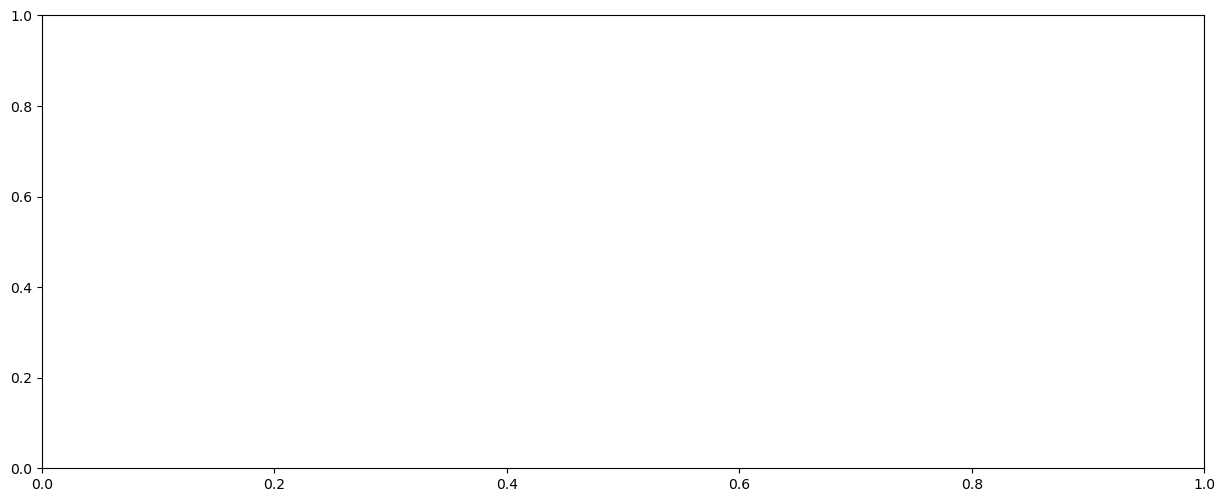

In [58]:
# Define different loss functions to test

# Dice Loss function
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice


# Focal Loss function
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = nn.functional.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

# Tversky Loss function
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, pred, target):
        true_pos = (pred * target).sum()
        false_neg = (target * (1 - pred)).sum()
        false_pos = ((1 - target) * pred).sum()
        tversky = (true_pos + self.smooth) / (true_pos + self.alpha * false_neg + self.beta * false_pos + self.smooth)
        return 1 - tversky

    
loss_functions = {
    'BCELoss': nn.BCELoss(),
    'DiceLoss': DiceLoss(),
    'BCEWithLogitsLoss': nn.BCEWithLogitsLoss(),
    'FocalLoss': FocalLoss(),
    'TverskyLoss': TverskyLoss()
}


def run_model(loss_functions, num_runs=5, num_epochs=25):
    all_results = {loss_name: {'train_losses': [], 'val_dice_scores': [], 'val_ious': []} for loss_name in loss_functions}

    for loss_name, criterion in loss_functions.items():
        print(f'Running with loss function: {loss_name}')
        

        model = UNet().to(device)
        model.to(device)
        criterion = criterion
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        train_losses = []
        val_dice_scores = []
        val_ious = []

        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
                images, masks = images.to(device), masks.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item() * images.size(0)

            epoch_loss /= len(train_loader.dataset)
            train_losses.append(epoch_loss)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

            # Validation
            model.eval()
            val_dice = 0.0
            val_iou = 0.0
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(device), masks.to(device)
                    outputs = model(images)
                    preds = outputs > 0.5
                    val_dice += dice_coefficient(preds, masks).item() * images.size(0)
                    val_iou += iou(preds, masks).item() * images.size(0)

            val_dice /= len(val_loader.dataset)
            val_iou /= len(val_loader.dataset)
            val_dice_scores.append(val_dice)
            val_ious.append(val_iou)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

        all_results[loss_name]['train_losses'].append(train_losses)
        all_results[loss_name]['val_dice_scores'].append(val_dice_scores)
        all_results[loss_name]['val_ious'].append(val_ious)

    return all_results


# Run the model with different loss functions and plot results
all_results = run_model(loss_functions, num_runs=5, num_epochs=25)



In [ ]:
# Plotting Loss function results

In [59]:
def plot_results(all_results, num_epochs):
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(15, 20))

    # Plot training losses
    plt.subplot(3, 1, 1)
    for loss_name, results in all_results.items():
        for i, train_losses in enumerate(results['train_losses']):
            plt.plot(epochs, train_losses, label=f'{loss_name}, Run {i + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot validation Dice scores
    plt.subplot(3, 1, 2)
    for loss_name, results in all_results.items():
        for i, val_dice_scores in enumerate(results['val_dice_scores']):
            plt.plot(epochs, val_dice_scores, label=f'{loss_name}, Run {i + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Dice Score')
    plt.title('Validation Dice Score Over Epochs')
    plt.legend()

    # Plot validation IoU scores
    plt.subplot(3, 1, 3)
    for loss_name, results in all_results.items():
        for i, val_ious in enumerate(results['val_ious']):
            plt.plot(epochs, val_ious, label=f'{loss_name}, Run {i + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation IoU')
    plt.title('Validation IoU Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

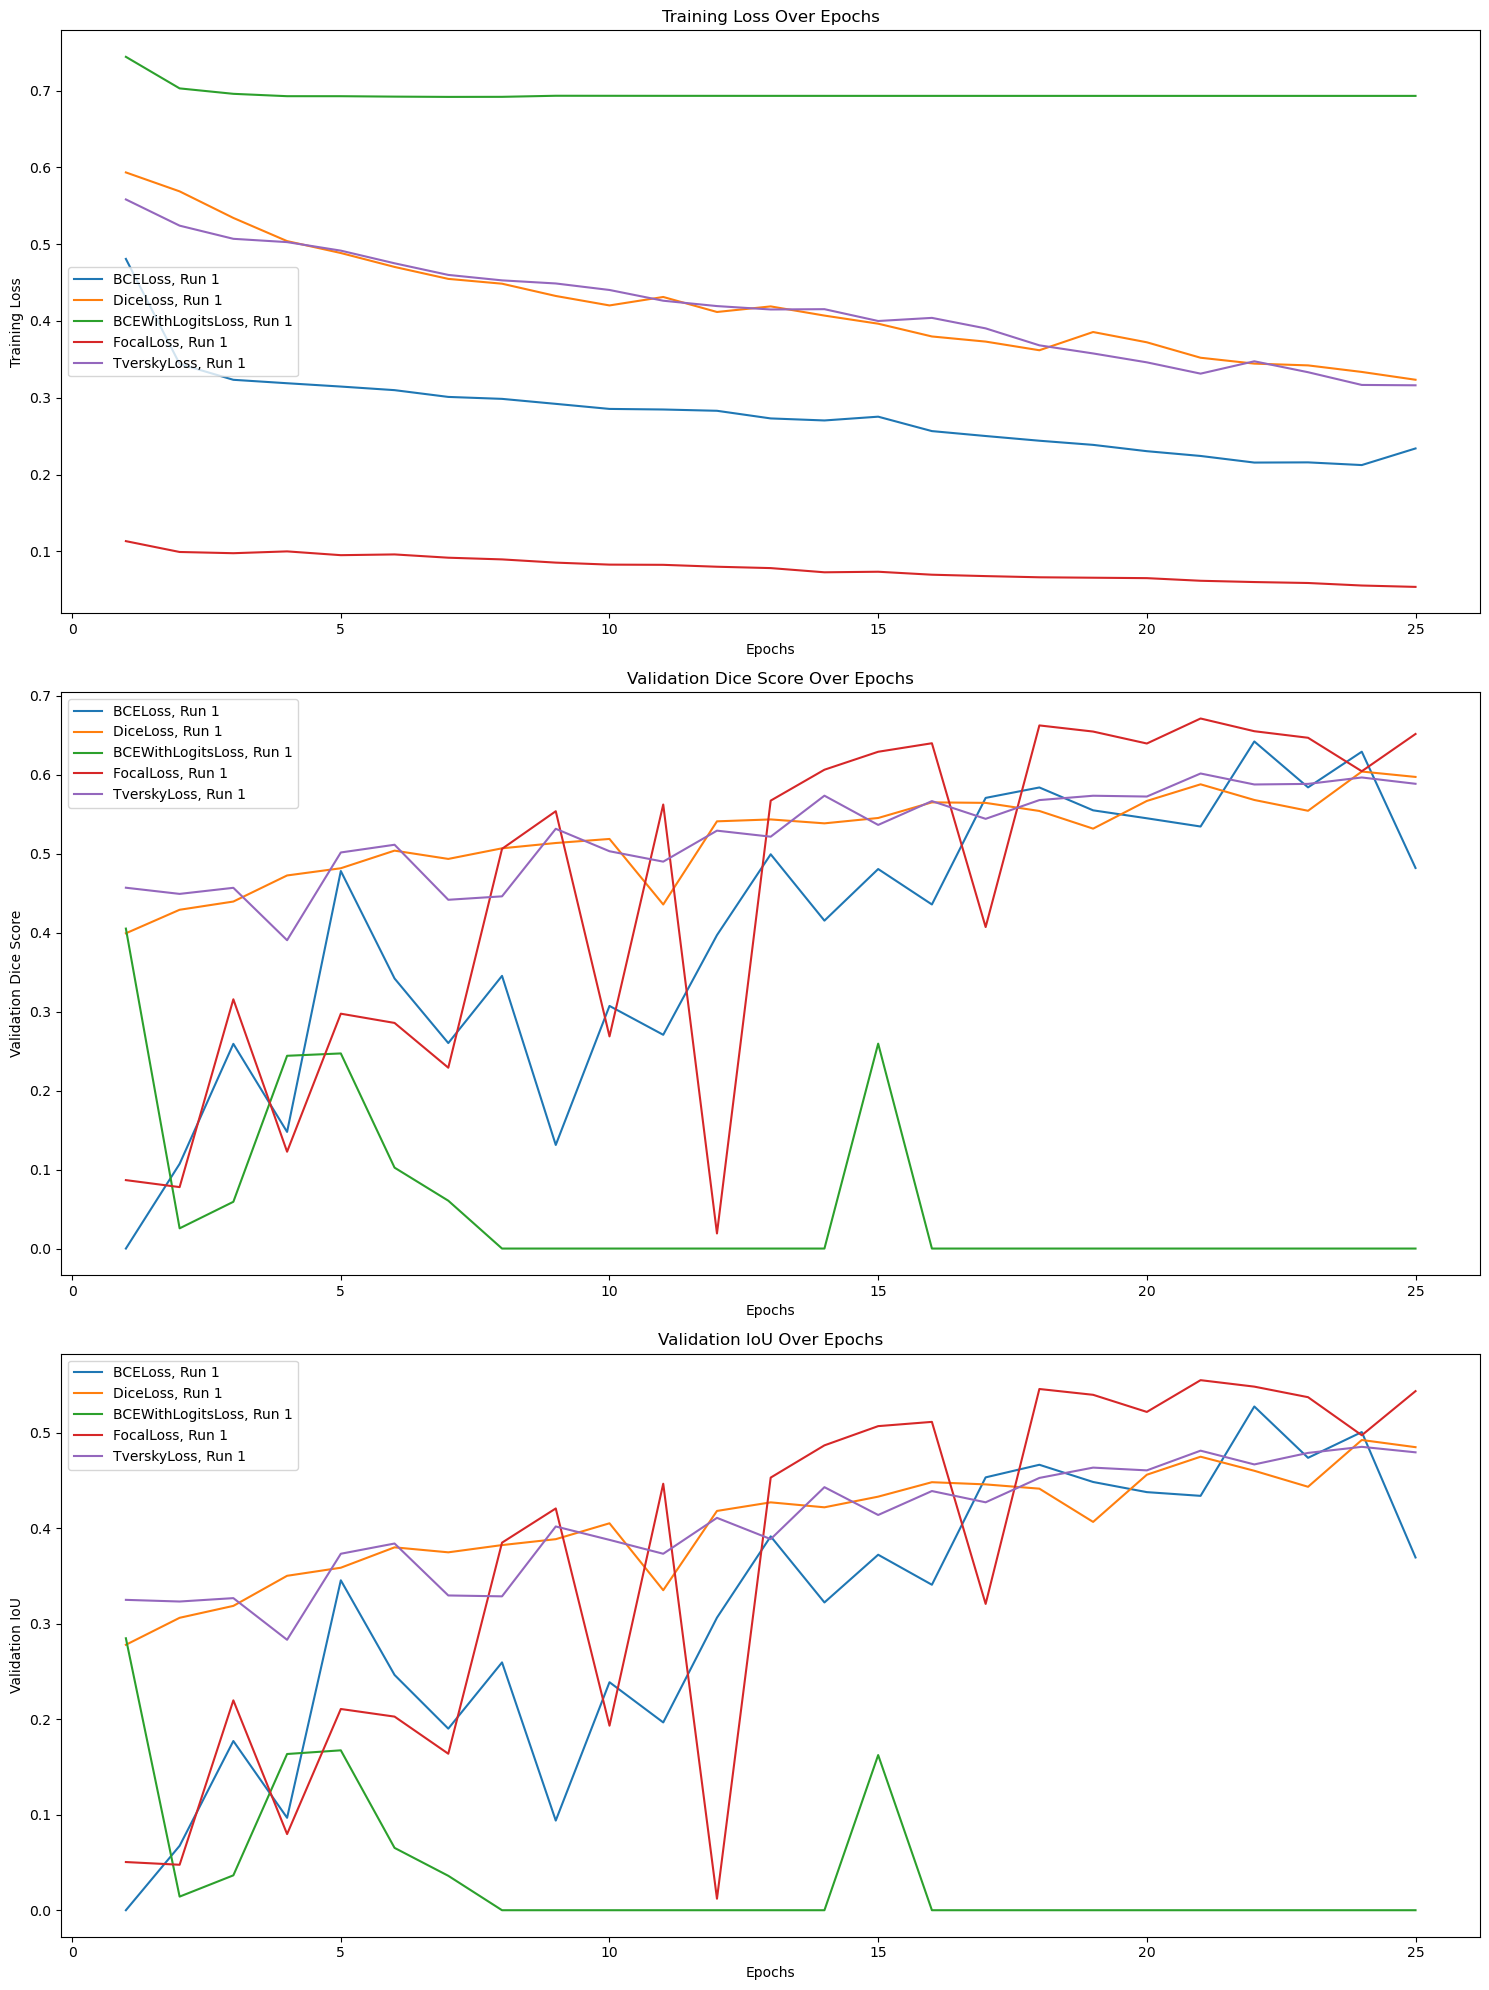

In [60]:
plot_results(all_results, num_epochs=25)

### Finding the best optimizer 

In [61]:
import matplotlib.pyplot as plt
import torch.optim as optim

def run_optimizer_experiments(optimizers, criterion, num_runs=1, num_epochs=25):
    all_results = {opt_name: {'train_losses': [], 'val_dice_scores': [], 'val_ious': []} for opt_name in optimizers}

    for opt_name, optimizer_class in optimizers.items():
        print(f'Running with optimizer: {opt_name}')

        # Initialize the model, optimizer for this run
        model = UNet().to(device)
        model.to(device)
        optimizer = optimizer_class(model.parameters())


        for run in range(num_runs):
            print(f'Run {run + 1}/{num_runs} for optimizer {opt_name}')

            train_losses = []
            val_dice_scores = []
            val_ious = []

            for epoch in range(num_epochs):
                model.train()
                epoch_loss = 0.0
                for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
                    images, masks = images.to(device), masks.to(device)

                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item() * images.size(0)

                epoch_loss /= len(train_loader.dataset)
                train_losses.append(epoch_loss)
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

                # Validation
                model.eval()
                val_dice = 0.0
                val_iou = 0.0
                with torch.no_grad():
                    for images, masks in val_loader:
                        images, masks = images.to(device), masks.to(device)
                        outputs = model(images)
                        preds = outputs > 0.5
                        val_dice += dice_coefficient(preds, masks).item() * images.size(0)
                        val_iou += iou(preds, masks).item() * images.size(0)

                val_dice /= len(val_loader.dataset)
                val_iou /= len(val_loader.dataset)
                val_dice_scores.append(val_dice)
                val_ious.append(val_iou)
                print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

            all_results[opt_name]['train_losses'].append(train_losses)
            all_results[opt_name]['val_dice_scores'].append(val_dice_scores)
            all_results[opt_name]['val_ious'].append(val_ious)

    return all_results



# Define optimizers to test
optimizers = {
    'SGD': lambda params: optim.SGD(params, lr=0.01, momentum=0.9),
    'Adam': lambda params: optim.Adam(params, lr=0.001),
    'RMSprop': lambda params: optim.RMSprop(params, lr=0.001),
    'Adagrad': lambda params: optim.Adagrad(params, lr=0.01),
    'AdamW': lambda params: optim.AdamW(params, lr=0.001)
}

# Define the loss function
criterion = nn.BCELoss()

In [62]:
# Run the optimizer experiments
all_results = run_optimizer_experiments(optimizers, criterion, num_runs=1, num_epochs=25)

Running with optimizer: SGD
Run 1/1 for optimizer SGD


Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:49<00:00,  1.83it/s]


Epoch [1/25], Loss: 0.4024
Epoch [1/25], Validation Dice: 0.0419, Validation IoU: 0.0246


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [2/25], Loss: 0.3453
Epoch [2/25], Validation Dice: 0.4140, Validation IoU: 0.2921


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:48<00:00,  1.85it/s]


Epoch [3/25], Loss: 0.3285
Epoch [3/25], Validation Dice: 0.1033, Validation IoU: 0.0598


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [4/25], Loss: 0.3141
Epoch [4/25], Validation Dice: 0.3888, Validation IoU: 0.2718


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:49<00:00,  1.83it/s]


Epoch [5/25], Loss: 0.3016
Epoch [5/25], Validation Dice: 0.4747, Validation IoU: 0.3488


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:49<00:00,  1.83it/s]


Epoch [6/25], Loss: 0.2966
Epoch [6/25], Validation Dice: 0.5074, Validation IoU: 0.3822


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:49<00:00,  1.83it/s]


Epoch [7/25], Loss: 0.2822
Epoch [7/25], Validation Dice: 0.1700, Validation IoU: 0.1124


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:49<00:00,  1.83it/s]


Epoch [8/25], Loss: 0.2675
Epoch [8/25], Validation Dice: 0.5928, Validation IoU: 0.4700


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:48<00:00,  1.83it/s]


Epoch [9/25], Loss: 0.2451
Epoch [9/25], Validation Dice: 0.5470, Validation IoU: 0.4195


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [10/25], Loss: 0.2289
Epoch [10/25], Validation Dice: 0.5636, Validation IoU: 0.4516


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [11/25], Loss: 0.2075
Epoch [11/25], Validation Dice: 0.4277, Validation IoU: 0.3320


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.83it/s]


Epoch [12/25], Loss: 0.1933
Epoch [12/25], Validation Dice: 0.7150, Validation IoU: 0.6051


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [13/25], Loss: 0.1793
Epoch [13/25], Validation Dice: 0.6306, Validation IoU: 0.5205


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [14/25], Loss: 0.1659
Epoch [14/25], Validation Dice: 0.7682, Validation IoU: 0.6686


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [15/25], Loss: 0.1473
Epoch [15/25], Validation Dice: 0.7114, Validation IoU: 0.6074


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [16/25], Loss: 0.1411
Epoch [16/25], Validation Dice: 0.6961, Validation IoU: 0.5736


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [17/25], Loss: 0.1332
Epoch [17/25], Validation Dice: 0.7414, Validation IoU: 0.6405


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [18/25], Loss: 0.1196
Epoch [18/25], Validation Dice: 0.7243, Validation IoU: 0.6251


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [19/25], Loss: 0.1009
Epoch [19/25], Validation Dice: 0.7458, Validation IoU: 0.6398


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [20/25], Loss: 0.0911
Epoch [20/25], Validation Dice: 0.7310, Validation IoU: 0.6252


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [21/25], Loss: 0.0793
Epoch [21/25], Validation Dice: 0.7834, Validation IoU: 0.6842


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [22/25], Loss: 0.0797
Epoch [22/25], Validation Dice: 0.7318, Validation IoU: 0.6366


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [23/25], Loss: 0.0696
Epoch [23/25], Validation Dice: 0.6978, Validation IoU: 0.5939


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [24/25], Loss: 0.0527
Epoch [24/25], Validation Dice: 0.7262, Validation IoU: 0.6265


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [25/25], Loss: 0.0691
Epoch [25/25], Validation Dice: 0.7531, Validation IoU: 0.6513
Running with optimizer: Adam
Run 1/1 for optimizer Adam


Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [1/25], Loss: 0.5156
Epoch [1/25], Validation Dice: 0.0004, Validation IoU: 0.0002


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [2/25], Loss: 0.3458
Epoch [2/25], Validation Dice: 0.4487, Validation IoU: 0.3187


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [3/25], Loss: 0.3244
Epoch [3/25], Validation Dice: 0.2384, Validation IoU: 0.1538


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [4/25], Loss: 0.3150
Epoch [4/25], Validation Dice: 0.3350, Validation IoU: 0.2314


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [5/25], Loss: 0.3088
Epoch [5/25], Validation Dice: 0.4807, Validation IoU: 0.3526


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [6/25], Loss: 0.2941
Epoch [6/25], Validation Dice: 0.3282, Validation IoU: 0.2432


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [7/25], Loss: 0.2796
Epoch [7/25], Validation Dice: 0.4833, Validation IoU: 0.3610


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [8/25], Loss: 0.2704
Epoch [8/25], Validation Dice: 0.4692, Validation IoU: 0.3657


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [9/25], Loss: 0.2570
Epoch [9/25], Validation Dice: 0.5264, Validation IoU: 0.4141


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [10/25], Loss: 0.2434
Epoch [10/25], Validation Dice: 0.6253, Validation IoU: 0.4962


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [11/25], Loss: 0.2370
Epoch [11/25], Validation Dice: 0.5895, Validation IoU: 0.4818


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [12/25], Loss: 0.2265
Epoch [12/25], Validation Dice: 0.6194, Validation IoU: 0.5081


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [13/25], Loss: 0.2115
Epoch [13/25], Validation Dice: 0.5014, Validation IoU: 0.4043


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [14/25], Loss: 0.2126
Epoch [14/25], Validation Dice: 0.6469, Validation IoU: 0.5189


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [15/25], Loss: 0.1937
Epoch [15/25], Validation Dice: 0.6898, Validation IoU: 0.5825


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [16/25], Loss: 0.1868
Epoch [16/25], Validation Dice: 0.6648, Validation IoU: 0.5496


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [17/25], Loss: 0.1747
Epoch [17/25], Validation Dice: 0.6158, Validation IoU: 0.5142


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [18/25], Loss: 0.1633
Epoch [18/25], Validation Dice: 0.6733, Validation IoU: 0.5660


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [19/25], Loss: 0.1545
Epoch [19/25], Validation Dice: 0.7008, Validation IoU: 0.5954


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [20/25], Loss: 0.1415
Epoch [20/25], Validation Dice: 0.7183, Validation IoU: 0.6119


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [21/25], Loss: 0.1342
Epoch [21/25], Validation Dice: 0.6671, Validation IoU: 0.5584


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [22/25], Loss: 0.1225
Epoch [22/25], Validation Dice: 0.7308, Validation IoU: 0.6282


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [23/25], Loss: 0.1123
Epoch [23/25], Validation Dice: 0.6841, Validation IoU: 0.5775


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [24/25], Loss: 0.0920
Epoch [24/25], Validation Dice: 0.7414, Validation IoU: 0.6390


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [25/25], Loss: 0.0837
Epoch [25/25], Validation Dice: 0.7165, Validation IoU: 0.6093
Running with optimizer: RMSprop
Run 1/1 for optimizer RMSprop


Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [1/25], Loss: 0.4130
Epoch [1/25], Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [2/25], Loss: 0.3386
Epoch [2/25], Validation Dice: 0.0107, Validation IoU: 0.0063


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:50<00:00,  1.82it/s]


Epoch [3/25], Loss: 0.3238
Epoch [3/25], Validation Dice: 0.4454, Validation IoU: 0.3177


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:50<00:00,  1.82it/s]


Epoch [4/25], Loss: 0.3188
Epoch [4/25], Validation Dice: 0.1184, Validation IoU: 0.0788


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [5/25], Loss: 0.3142
Epoch [5/25], Validation Dice: 0.4263, Validation IoU: 0.2967


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [6/25], Loss: 0.3105
Epoch [6/25], Validation Dice: 0.0077, Validation IoU: 0.0046


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [7/25], Loss: 0.3046
Epoch [7/25], Validation Dice: 0.1263, Validation IoU: 0.0842


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [8/25], Loss: 0.2972
Epoch [8/25], Validation Dice: 0.1035, Validation IoU: 0.0700


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [9/25], Loss: 0.2945
Epoch [9/25], Validation Dice: 0.4596, Validation IoU: 0.3422


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [10/25], Loss: 0.2855
Epoch [10/25], Validation Dice: 0.2568, Validation IoU: 0.1847


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [11/25], Loss: 0.2802
Epoch [11/25], Validation Dice: 0.4413, Validation IoU: 0.3394


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [12/25], Loss: 0.2756
Epoch [12/25], Validation Dice: 0.5095, Validation IoU: 0.3919


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [13/25], Loss: 0.2638
Epoch [13/25], Validation Dice: 0.5780, Validation IoU: 0.4514


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [14/25], Loss: 0.2543
Epoch [14/25], Validation Dice: 0.5771, Validation IoU: 0.4636


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [15/25], Loss: 0.2509
Epoch [15/25], Validation Dice: 0.5815, Validation IoU: 0.4678


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [16/25], Loss: 0.2371
Epoch [16/25], Validation Dice: 0.5829, Validation IoU: 0.4698


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [17/25], Loss: 0.2346
Epoch [17/25], Validation Dice: 0.5552, Validation IoU: 0.4519


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [18/25], Loss: 0.2228
Epoch [18/25], Validation Dice: 0.5345, Validation IoU: 0.4353


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.82it/s]


Epoch [19/25], Loss: 0.2150
Epoch [19/25], Validation Dice: 0.6545, Validation IoU: 0.5429


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [20/25], Loss: 0.2075
Epoch [20/25], Validation Dice: 0.5759, Validation IoU: 0.4710


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [21/25], Loss: 0.1969
Epoch [21/25], Validation Dice: 0.6680, Validation IoU: 0.5609


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [22/25], Loss: 0.1886
Epoch [22/25], Validation Dice: 0.6908, Validation IoU: 0.5823


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [23/25], Loss: 0.1831
Epoch [23/25], Validation Dice: 0.4251, Validation IoU: 0.3006


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [24/25], Loss: 0.1758
Epoch [24/25], Validation Dice: 0.6055, Validation IoU: 0.5036


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


Epoch [25/25], Loss: 0.1665
Epoch [25/25], Validation Dice: 0.6587, Validation IoU: 0.5554
Running with optimizer: Adagrad
Run 1/1 for optimizer Adagrad


Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [1/25], Loss: 0.4162
Epoch [1/25], Validation Dice: 0.2928, Validation IoU: 0.2020


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [2/25], Loss: 0.3290
Epoch [2/25], Validation Dice: 0.1382, Validation IoU: 0.0898


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [3/25], Loss: 0.3152
Epoch [3/25], Validation Dice: 0.0806, Validation IoU: 0.0507


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:49<00:00,  1.83it/s]


Epoch [4/25], Loss: 0.3036
Epoch [4/25], Validation Dice: 0.1215, Validation IoU: 0.0801


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [5/25], Loss: 0.2927
Epoch [5/25], Validation Dice: 0.2092, Validation IoU: 0.1434


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [6/25], Loss: 0.2821
Epoch [6/25], Validation Dice: 0.5405, Validation IoU: 0.4131


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [7/25], Loss: 0.2702
Epoch [7/25], Validation Dice: 0.4385, Validation IoU: 0.3379


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [8/25], Loss: 0.2613
Epoch [8/25], Validation Dice: 0.3554, Validation IoU: 0.2387


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [9/25], Loss: 0.2468
Epoch [9/25], Validation Dice: 0.5293, Validation IoU: 0.4183


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [10/25], Loss: 0.2368
Epoch [10/25], Validation Dice: 0.5409, Validation IoU: 0.4304


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.83it/s]


Epoch [11/25], Loss: 0.2258
Epoch [11/25], Validation Dice: 0.5374, Validation IoU: 0.4295


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.83it/s]


Epoch [12/25], Loss: 0.2170
Epoch [12/25], Validation Dice: 0.5835, Validation IoU: 0.4739


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [13/25], Loss: 0.2024
Epoch [13/25], Validation Dice: 0.6739, Validation IoU: 0.5592


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.83it/s]


Epoch [14/25], Loss: 0.1964
Epoch [14/25], Validation Dice: 0.6096, Validation IoU: 0.4960


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.83it/s]


Epoch [15/25], Loss: 0.1847
Epoch [15/25], Validation Dice: 0.6442, Validation IoU: 0.5376


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.83it/s]


Epoch [16/25], Loss: 0.1754
Epoch [16/25], Validation Dice: 0.6606, Validation IoU: 0.5565


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [17/25], Loss: 0.1687
Epoch [17/25], Validation Dice: 0.6732, Validation IoU: 0.5670


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [18/25], Loss: 0.1628
Epoch [18/25], Validation Dice: 0.6535, Validation IoU: 0.5441


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [19/25], Loss: 0.1590
Epoch [19/25], Validation Dice: 0.6975, Validation IoU: 0.5890


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [20/25], Loss: 0.1434
Epoch [20/25], Validation Dice: 0.7256, Validation IoU: 0.6246


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [21/25], Loss: 0.1356
Epoch [21/25], Validation Dice: 0.6915, Validation IoU: 0.5875


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [22/25], Loss: 0.1237
Epoch [22/25], Validation Dice: 0.6951, Validation IoU: 0.5880


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [23/25], Loss: 0.1247
Epoch [23/25], Validation Dice: 0.7158, Validation IoU: 0.6118


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


Epoch [24/25], Loss: 0.1087
Epoch [24/25], Validation Dice: 0.6922, Validation IoU: 0.5860


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.82it/s]


Epoch [25/25], Loss: 0.1031
Epoch [25/25], Validation Dice: 0.7327, Validation IoU: 0.6301
Running with optimizer: AdamW
Run 1/1 for optimizer AdamW


Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [1/25], Loss: 0.5144
Epoch [1/25], Validation Dice: 0.0472, Validation IoU: 0.0282


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [2/25], Loss: 0.3315
Epoch [2/25], Validation Dice: 0.2903, Validation IoU: 0.1975


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [3/25], Loss: 0.3130
Epoch [3/25], Validation Dice: 0.4379, Validation IoU: 0.3189


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [4/25], Loss: 0.2980
Epoch [4/25], Validation Dice: 0.2718, Validation IoU: 0.2020


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [5/25], Loss: 0.2917
Epoch [5/25], Validation Dice: 0.4277, Validation IoU: 0.3165


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [6/25], Loss: 0.2812
Epoch [6/25], Validation Dice: 0.2407, Validation IoU: 0.1795


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.77it/s]


Epoch [7/25], Loss: 0.2729
Epoch [7/25], Validation Dice: 0.5517, Validation IoU: 0.4351


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [8/25], Loss: 0.2791
Epoch [8/25], Validation Dice: 0.3556, Validation IoU: 0.2721


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [9/25], Loss: 0.2615
Epoch [9/25], Validation Dice: 0.4843, Validation IoU: 0.3853


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [10/25], Loss: 0.2489
Epoch [10/25], Validation Dice: 0.5121, Validation IoU: 0.4066


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [11/25], Loss: 0.2443
Epoch [11/25], Validation Dice: 0.2643, Validation IoU: 0.2053


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [12/25], Loss: 0.2376
Epoch [12/25], Validation Dice: 0.5829, Validation IoU: 0.4738


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [13/25], Loss: 0.2265
Epoch [13/25], Validation Dice: 0.5004, Validation IoU: 0.4000


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [14/25], Loss: 0.2165
Epoch [14/25], Validation Dice: 0.4720, Validation IoU: 0.3731


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [15/25], Loss: 0.2180
Epoch [15/25], Validation Dice: 0.6500, Validation IoU: 0.5344


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [16/25], Loss: 0.2074
Epoch [16/25], Validation Dice: 0.0747, Validation IoU: 0.0527


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [17/25], Loss: 0.2014
Epoch [17/25], Validation Dice: 0.5806, Validation IoU: 0.4727


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [18/25], Loss: 0.1924
Epoch [18/25], Validation Dice: 0.6610, Validation IoU: 0.5434


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [19/25], Loss: 0.1763
Epoch [19/25], Validation Dice: 0.6860, Validation IoU: 0.5667


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [20/25], Loss: 0.1701
Epoch [20/25], Validation Dice: 0.6791, Validation IoU: 0.5551


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [21/25], Loss: 0.1560
Epoch [21/25], Validation Dice: 0.6539, Validation IoU: 0.5412


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [22/25], Loss: 0.1554
Epoch [22/25], Validation Dice: 0.6260, Validation IoU: 0.5121


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [23/25], Loss: 0.1452
Epoch [23/25], Validation Dice: 0.6358, Validation IoU: 0.5098


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [24/25], Loss: 0.1508
Epoch [24/25], Validation Dice: 0.6359, Validation IoU: 0.5170


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [25/25], Loss: 0.1300
Epoch [25/25], Validation Dice: 0.6899, Validation IoU: 0.5714


In [63]:
def plot_optimizer_results(all_results, num_epochs):
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(15, 20))

    # Plot training losses
    plt.subplot(3, 1, 1)
    for opt_name, results in all_results.items():
        for i, train_losses in enumerate(results['train_losses']):
            plt.plot(epochs, train_losses, label=f'{opt_name}, Run {i + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot validation Dice scores
    plt.subplot(3, 1, 2)
    for opt_name, results in all_results.items():
        for i, val_dice_scores in enumerate(results['val_dice_scores']):
            plt.plot(epochs, val_dice_scores, label=f'{opt_name}, Run {i + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Dice Score')
    plt.title('Validation Dice Score Over Epochs')
    plt.legend()

    # Plot validation IoU scores
    plt.subplot(3, 1, 3)
    for opt_name, results in all_results.items():
        for i, val_ious in enumerate(results['val_ious']):
            plt.plot(epochs, val_ious, label=f'{opt_name}, Run {i + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation IoU')
    plt.title('Validation IoU Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

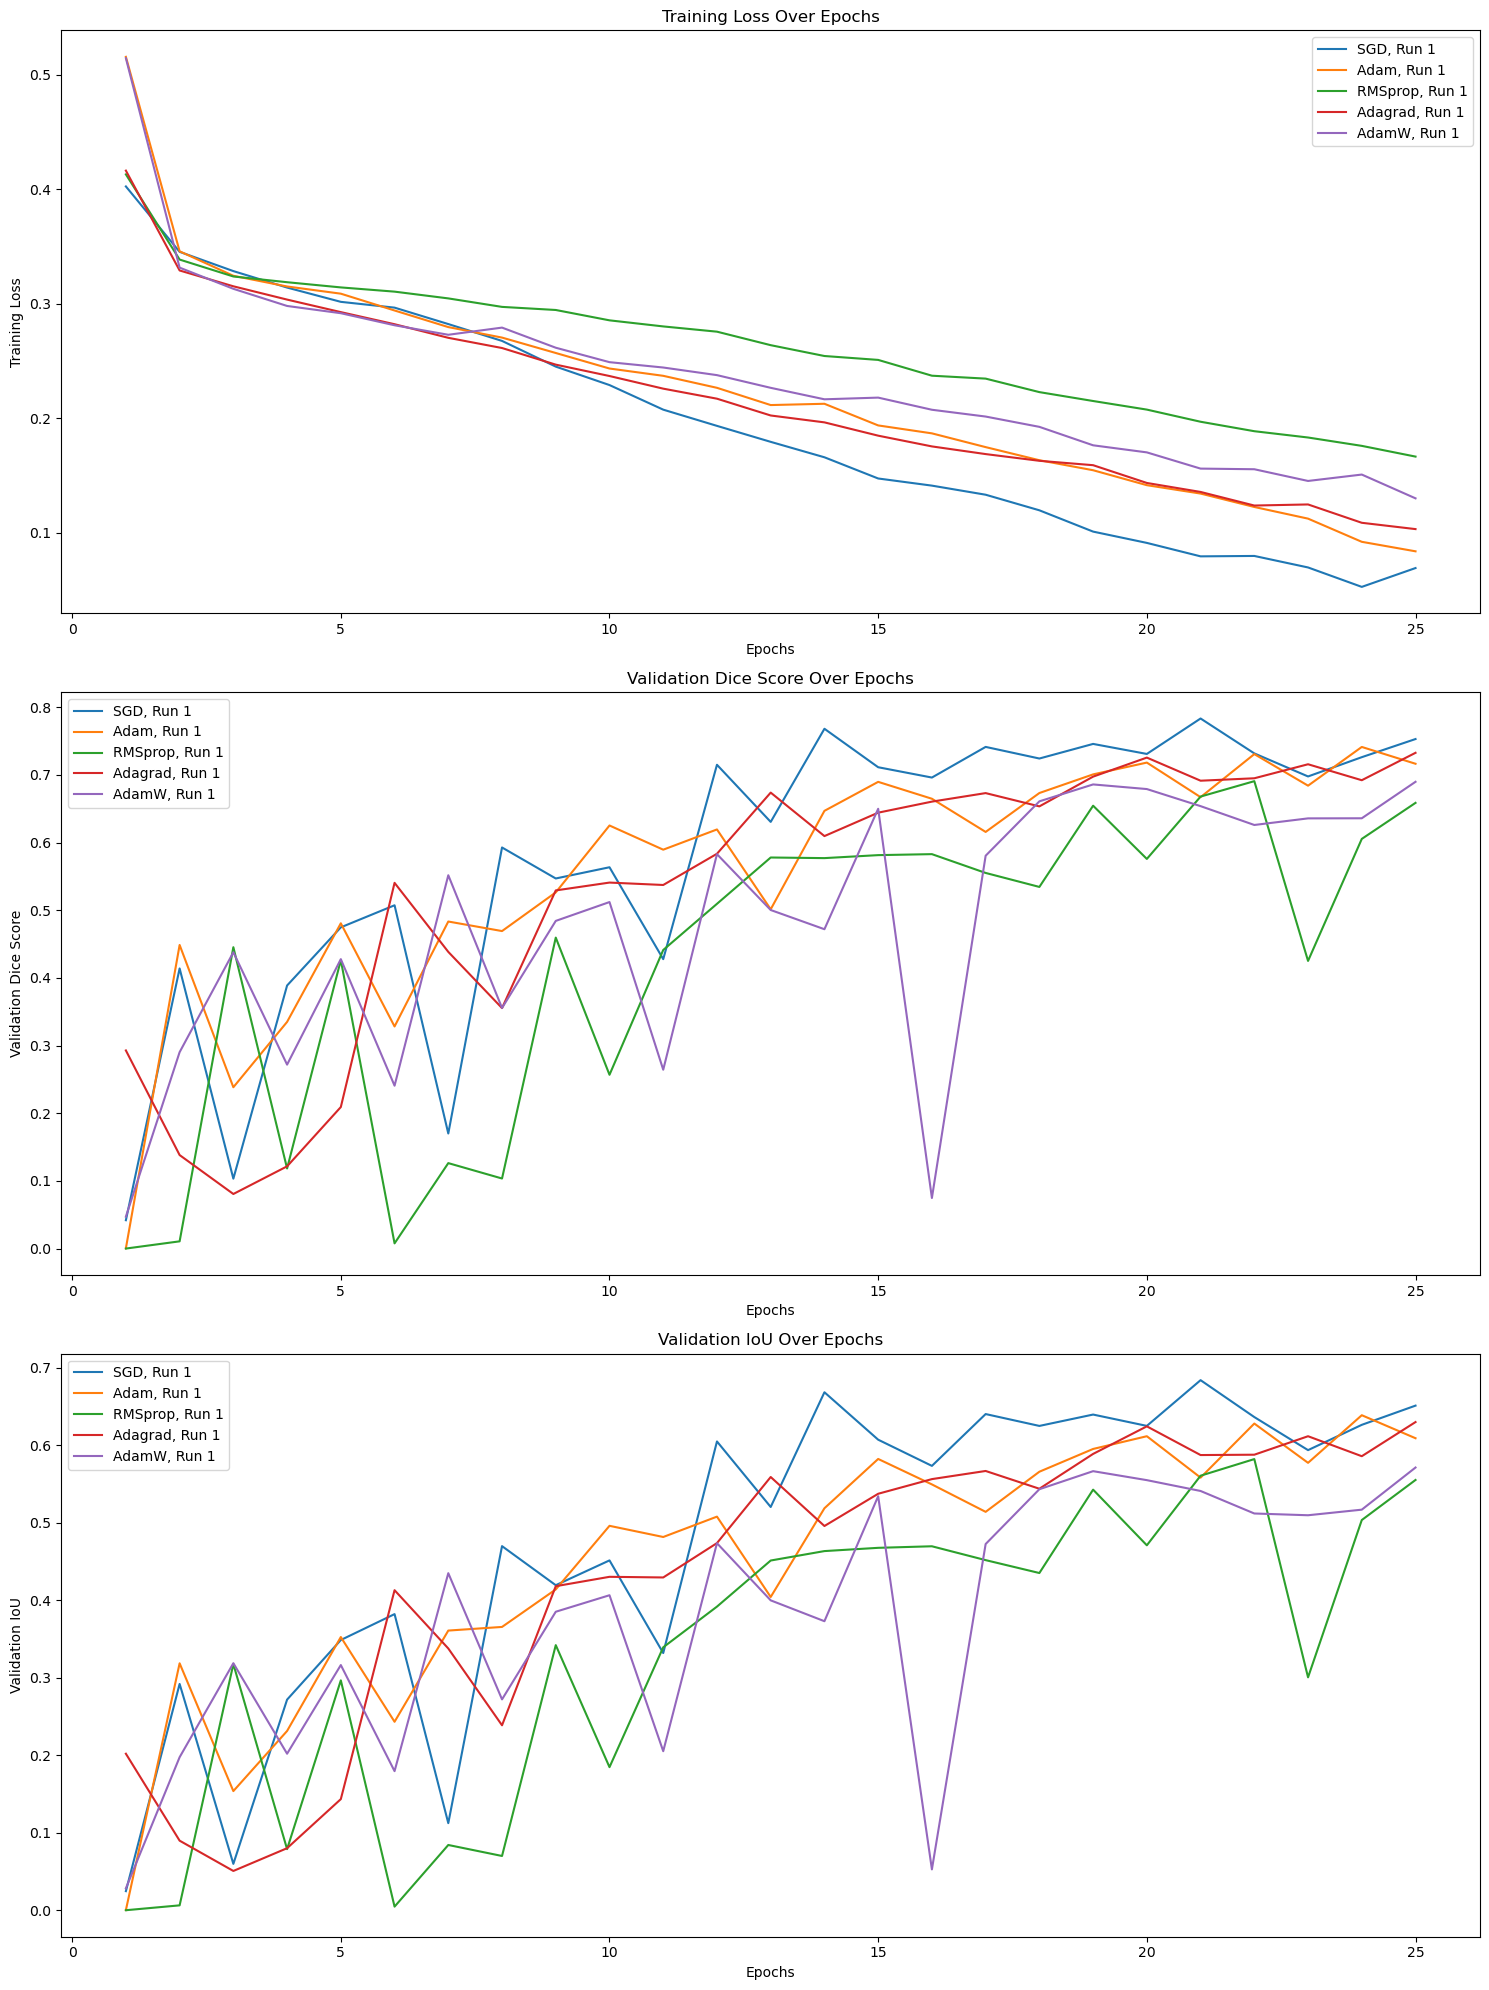

In [64]:
# Plot the results
plot_optimizer_results(all_results, num_epochs=25)

### Finding the best learning rate for the dataset

In [65]:
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

def run_lr_experiments(learning_rates, criterion, num_runs=1, num_epochs=25):
    all_results = {
        f'Adam_lr{lr}': {'train_losses': [], 'val_dice_scores': [], 'val_ious': []}
        for lr in learning_rates
    }

    for lr in learning_rates:
        exp_name = f'Adam_lr{lr}'
        print(f'Running with Adam optimizer and learning rate: {lr}')

        for run in range(num_runs):
            print(f'Run {run + 1}/{num_runs} for learning rate {lr}')
            
            # Initialize the model and optimizer for this run
            model = UNet().to(device)
            model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr)

            train_losses = []
            val_dice_scores = []
            val_ious = []

            for epoch in range(num_epochs):
                model.train()
                epoch_loss = 0.0
                for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
                    images, masks = images.to(device), masks.to(device)

                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item() * images.size(0)

                epoch_loss /= len(train_loader.dataset)
                train_losses.append(epoch_loss)
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

                # Validation
                model.eval()
                val_dice = 0.0
                val_iou = 0.0
                with torch.no_grad():
                    for images, masks in val_loader:
                        images, masks = images.to(device), masks.to(device)
                        outputs = model(images)
                        preds = outputs > 0.5
                        val_dice += dice_coefficient(preds, masks).item() * images.size(0)
                        val_iou += iou(preds, masks).item() * images.size(0)

                val_dice /= len(val_loader.dataset)
                val_iou /= len(val_loader.dataset)
                val_dice_scores.append(val_dice)
                val_ious.append(val_iou)
                print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

            all_results[exp_name]['train_losses'].append(train_losses)
            all_results[exp_name]['val_dice_scores'].append(val_dice_scores)
            all_results[exp_name]['val_ious'].append(val_ious)

    return all_results


# Define learning rates to test
learning_rates = [0.01, 0.001, 0.0001, 0.05, 0.005]

# Define the loss function
criterion = nn.BCELoss()

# Run the learning rate experiments and plot results
all_results = run_lr_experiments(learning_rates, criterion, num_runs=1, num_epochs=25)

Running with Adam optimizer and learning rate: 0.01
Run 1/1 for learning rate 0.01


Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [1/25], Loss: 0.3673
Epoch [1/25], Validation Dice: 0.4131, Validation IoU: 0.2937


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [2/25], Loss: 0.3280
Epoch [2/25], Validation Dice: 0.3837, Validation IoU: 0.2703


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [3/25], Loss: 0.3147
Epoch [3/25], Validation Dice: 0.4645, Validation IoU: 0.3380


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [4/25], Loss: 0.3112
Epoch [4/25], Validation Dice: 0.3682, Validation IoU: 0.2618


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [5/25], Loss: 0.3013
Epoch [5/25], Validation Dice: 0.4240, Validation IoU: 0.3108


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [6/25], Loss: 0.3002
Epoch [6/25], Validation Dice: 0.5000, Validation IoU: 0.3723


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [7/25], Loss: 0.2894
Epoch [7/25], Validation Dice: 0.4902, Validation IoU: 0.3643


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [8/25], Loss: 0.2806
Epoch [8/25], Validation Dice: 0.3976, Validation IoU: 0.2858


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [9/25], Loss: 0.2745
Epoch [9/25], Validation Dice: 0.2604, Validation IoU: 0.1957


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [10/25], Loss: 0.2642
Epoch [10/25], Validation Dice: 0.1094, Validation IoU: 0.0745


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [11/25], Loss: 0.2596
Epoch [11/25], Validation Dice: 0.4516, Validation IoU: 0.3502


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [12/25], Loss: 0.2493
Epoch [12/25], Validation Dice: 0.6139, Validation IoU: 0.4952


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [13/25], Loss: 0.2396
Epoch [13/25], Validation Dice: 0.4643, Validation IoU: 0.3652


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [14/25], Loss: 0.2316
Epoch [14/25], Validation Dice: 0.5245, Validation IoU: 0.4217


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [15/25], Loss: 0.2184
Epoch [15/25], Validation Dice: 0.5783, Validation IoU: 0.4616


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [16/25], Loss: 0.2116
Epoch [16/25], Validation Dice: 0.6840, Validation IoU: 0.5567


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [17/25], Loss: 0.2044
Epoch [17/25], Validation Dice: 0.5311, Validation IoU: 0.4229


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [18/25], Loss: 0.1884
Epoch [18/25], Validation Dice: 0.5811, Validation IoU: 0.4697


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [19/25], Loss: 0.1855
Epoch [19/25], Validation Dice: 0.6587, Validation IoU: 0.5423


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [20/25], Loss: 0.1749
Epoch [20/25], Validation Dice: 0.6431, Validation IoU: 0.5317


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [21/25], Loss: 0.1592
Epoch [21/25], Validation Dice: 0.7061, Validation IoU: 0.5924


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [22/25], Loss: 0.1566
Epoch [22/25], Validation Dice: 0.5838, Validation IoU: 0.4757


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [23/25], Loss: 0.1537
Epoch [23/25], Validation Dice: 0.7083, Validation IoU: 0.5925


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [24/25], Loss: 0.1350
Epoch [24/25], Validation Dice: 0.6725, Validation IoU: 0.5468


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [25/25], Loss: 0.1293
Epoch [25/25], Validation Dice: 0.6769, Validation IoU: 0.5594
Running with Adam optimizer and learning rate: 0.001
Run 1/1 for learning rate 0.001


Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [1/25], Loss: 0.5084
Epoch [1/25], Validation Dice: 0.2411, Validation IoU: 0.1586


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [2/25], Loss: 0.3344
Epoch [2/25], Validation Dice: 0.1123, Validation IoU: 0.0734


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [3/25], Loss: 0.3191
Epoch [3/25], Validation Dice: 0.2584, Validation IoU: 0.1769


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [4/25], Loss: 0.3082
Epoch [4/25], Validation Dice: 0.4696, Validation IoU: 0.3418


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [5/25], Loss: 0.2924
Epoch [5/25], Validation Dice: 0.0001, Validation IoU: 0.0000


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [6/25], Loss: 0.2828
Epoch [6/25], Validation Dice: 0.4838, Validation IoU: 0.3659


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [7/25], Loss: 0.2754
Epoch [7/25], Validation Dice: 0.5413, Validation IoU: 0.4171


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [8/25], Loss: 0.2655
Epoch [8/25], Validation Dice: 0.5216, Validation IoU: 0.4090


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [9/25], Loss: 0.2544
Epoch [9/25], Validation Dice: 0.4706, Validation IoU: 0.3659


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [10/25], Loss: 0.2536
Epoch [10/25], Validation Dice: 0.5747, Validation IoU: 0.4507


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [11/25], Loss: 0.2392
Epoch [11/25], Validation Dice: 0.6321, Validation IoU: 0.5150


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [12/25], Loss: 0.2307
Epoch [12/25], Validation Dice: 0.5916, Validation IoU: 0.4827


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [13/25], Loss: 0.2212
Epoch [13/25], Validation Dice: 0.6537, Validation IoU: 0.5367


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [14/25], Loss: 0.2109
Epoch [14/25], Validation Dice: 0.6002, Validation IoU: 0.4890


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [15/25], Loss: 0.2045
Epoch [15/25], Validation Dice: 0.6793, Validation IoU: 0.5633


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [16/25], Loss: 0.1914
Epoch [16/25], Validation Dice: 0.6646, Validation IoU: 0.5576


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [17/25], Loss: 0.1773
Epoch [17/25], Validation Dice: 0.6451, Validation IoU: 0.5409


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [18/25], Loss: 0.1750
Epoch [18/25], Validation Dice: 0.4932, Validation IoU: 0.3922


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [19/25], Loss: 0.1817
Epoch [19/25], Validation Dice: 0.6508, Validation IoU: 0.5528


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [20/25], Loss: 0.1540
Epoch [20/25], Validation Dice: 0.7110, Validation IoU: 0.6037


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [21/25], Loss: 0.1310
Epoch [21/25], Validation Dice: 0.7049, Validation IoU: 0.6000


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [22/25], Loss: 0.1174
Epoch [22/25], Validation Dice: 0.7127, Validation IoU: 0.6004


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [23/25], Loss: 0.1033
Epoch [23/25], Validation Dice: 0.6985, Validation IoU: 0.5792


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [24/25], Loss: 0.0914
Epoch [24/25], Validation Dice: 0.6931, Validation IoU: 0.5944


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [25/25], Loss: 0.0855
Epoch [25/25], Validation Dice: 0.6954, Validation IoU: 0.5880
Running with Adam optimizer and learning rate: 0.0001
Run 1/1 for learning rate 0.0001


Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [1/25], Loss: 0.6109
Epoch [1/25], Validation Dice: 0.4859, Validation IoU: 0.3545


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [2/25], Loss: 0.5585
Epoch [2/25], Validation Dice: 0.5068, Validation IoU: 0.3697


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [3/25], Loss: 0.5457
Epoch [3/25], Validation Dice: 0.5223, Validation IoU: 0.3839


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [4/25], Loss: 0.5243
Epoch [4/25], Validation Dice: 0.5399, Validation IoU: 0.4049


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [5/25], Loss: 0.4519
Epoch [5/25], Validation Dice: 0.4643, Validation IoU: 0.3404


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [6/25], Loss: 0.4455
Epoch [6/25], Validation Dice: 0.4927, Validation IoU: 0.3604


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [7/25], Loss: 0.3680
Epoch [7/25], Validation Dice: 0.5229, Validation IoU: 0.4020


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [8/25], Loss: 0.3424
Epoch [8/25], Validation Dice: 0.5974, Validation IoU: 0.4702


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [9/25], Loss: 0.3151
Epoch [9/25], Validation Dice: 0.6530, Validation IoU: 0.5331


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [10/25], Loss: 0.2850
Epoch [10/25], Validation Dice: 0.6077, Validation IoU: 0.4938


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [11/25], Loss: 0.2661
Epoch [11/25], Validation Dice: 0.4848, Validation IoU: 0.3741


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [12/25], Loss: 0.2390
Epoch [12/25], Validation Dice: 0.6393, Validation IoU: 0.5310


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [13/25], Loss: 0.2217
Epoch [13/25], Validation Dice: 0.6722, Validation IoU: 0.5646


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [14/25], Loss: 0.2151
Epoch [14/25], Validation Dice: 0.7170, Validation IoU: 0.6101


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [15/25], Loss: 0.1969
Epoch [15/25], Validation Dice: 0.7344, Validation IoU: 0.6333


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [16/25], Loss: 0.1820
Epoch [16/25], Validation Dice: 0.7329, Validation IoU: 0.6355


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [17/25], Loss: 0.1619
Epoch [17/25], Validation Dice: 0.6947, Validation IoU: 0.5844


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [18/25], Loss: 0.1571
Epoch [18/25], Validation Dice: 0.7301, Validation IoU: 0.6338


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [19/25], Loss: 0.1427
Epoch [19/25], Validation Dice: 0.6530, Validation IoU: 0.5513


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [20/25], Loss: 0.1265
Epoch [20/25], Validation Dice: 0.7279, Validation IoU: 0.6337


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [21/25], Loss: 0.1149
Epoch [21/25], Validation Dice: 0.7350, Validation IoU: 0.6405


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [22/25], Loss: 0.0977
Epoch [22/25], Validation Dice: 0.7318, Validation IoU: 0.6276


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [23/25], Loss: 0.0948
Epoch [23/25], Validation Dice: 0.7734, Validation IoU: 0.6808


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [24/25], Loss: 0.0866
Epoch [24/25], Validation Dice: 0.7411, Validation IoU: 0.6436


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [25/25], Loss: 0.0774
Epoch [25/25], Validation Dice: 0.6377, Validation IoU: 0.5455
Running with Adam optimizer and learning rate: 0.05
Run 1/1 for learning rate 0.05


Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [1/25], Loss: 0.3874
Epoch [1/25], Validation Dice: 0.3577, Validation IoU: 0.2471


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [2/25], Loss: 0.3483
Epoch [2/25], Validation Dice: 0.0276, Validation IoU: 0.0162


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [3/25], Loss: 0.3403
Epoch [3/25], Validation Dice: 0.0080, Validation IoU: 0.0041


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [4/25], Loss: 0.3415
Epoch [4/25], Validation Dice: 0.2053, Validation IoU: 0.1390


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [5/25], Loss: 0.3407
Epoch [5/25], Validation Dice: 0.0014, Validation IoU: 0.0007


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [6/25], Loss: 0.3300
Epoch [6/25], Validation Dice: 0.4220, Validation IoU: 0.3023


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [7/25], Loss: 0.3278
Epoch [7/25], Validation Dice: 0.0182, Validation IoU: 0.0118


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [8/25], Loss: 0.3164
Epoch [8/25], Validation Dice: 0.4295, Validation IoU: 0.3014


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [9/25], Loss: 0.3156
Epoch [9/25], Validation Dice: 0.5145, Validation IoU: 0.3787


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [10/25], Loss: 0.3031
Epoch [10/25], Validation Dice: 0.0425, Validation IoU: 0.0235


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [11/25], Loss: 0.2997
Epoch [11/25], Validation Dice: 0.2519, Validation IoU: 0.1820


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [12/25], Loss: 0.3011
Epoch [12/25], Validation Dice: 0.0806, Validation IoU: 0.0491


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [13/25], Loss: 0.2839
Epoch [13/25], Validation Dice: 0.4719, Validation IoU: 0.3612


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [14/25], Loss: 0.2750
Epoch [14/25], Validation Dice: 0.5419, Validation IoU: 0.4043


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [15/25], Loss: 0.2699
Epoch [15/25], Validation Dice: 0.5534, Validation IoU: 0.4160


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.77it/s]


Epoch [16/25], Loss: 0.2547
Epoch [16/25], Validation Dice: 0.4201, Validation IoU: 0.3208


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [17/25], Loss: 0.2498
Epoch [17/25], Validation Dice: 0.5416, Validation IoU: 0.4308


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [18/25], Loss: 0.2406
Epoch [18/25], Validation Dice: 0.5916, Validation IoU: 0.4577


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [19/25], Loss: 0.2336
Epoch [19/25], Validation Dice: 0.6501, Validation IoU: 0.5224


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [20/25], Loss: 0.2232
Epoch [20/25], Validation Dice: 0.6256, Validation IoU: 0.4960


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [21/25], Loss: 0.2158
Epoch [21/25], Validation Dice: 0.6625, Validation IoU: 0.5407


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [22/25], Loss: 0.2126
Epoch [22/25], Validation Dice: 0.6377, Validation IoU: 0.5091


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [23/25], Loss: 0.1977
Epoch [23/25], Validation Dice: 0.6397, Validation IoU: 0.5236


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [24/25], Loss: 0.1890
Epoch [24/25], Validation Dice: 0.6466, Validation IoU: 0.5255


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [25/25], Loss: 0.1892
Epoch [25/25], Validation Dice: 0.6919, Validation IoU: 0.5782
Running with Adam optimizer and learning rate: 0.005
Run 1/1 for learning rate 0.005


Epoch 1/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [1/25], Loss: 0.3902
Epoch [1/25], Validation Dice: 0.2609, Validation IoU: 0.1683


Epoch 2/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [2/25], Loss: 0.3300
Epoch [2/25], Validation Dice: 0.3590, Validation IoU: 0.2568


Epoch 3/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [3/25], Loss: 0.3228
Epoch [3/25], Validation Dice: 0.2225, Validation IoU: 0.1510


Epoch 4/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [4/25], Loss: 0.3144
Epoch [4/25], Validation Dice: 0.2353, Validation IoU: 0.1589


Epoch 5/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [5/25], Loss: 0.3096
Epoch [5/25], Validation Dice: 0.4333, Validation IoU: 0.3179


Epoch 6/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [6/25], Loss: 0.2990
Epoch [6/25], Validation Dice: 0.3569, Validation IoU: 0.2719


Epoch 7/25: 100%|█████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [7/25], Loss: 0.2928
Epoch [7/25], Validation Dice: 0.1053, Validation IoU: 0.0752


Epoch 8/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [8/25], Loss: 0.2835
Epoch [8/25], Validation Dice: 0.4184, Validation IoU: 0.3132


Epoch 9/25: 100%|█████████████████████████████| 200/200 [01:52<00:00,  1.77it/s]


Epoch [9/25], Loss: 0.2814
Epoch [9/25], Validation Dice: 0.4312, Validation IoU: 0.3283


Epoch 10/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [10/25], Loss: 0.2708
Epoch [10/25], Validation Dice: 0.3826, Validation IoU: 0.2894


Epoch 11/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [11/25], Loss: 0.2614
Epoch [11/25], Validation Dice: 0.3612, Validation IoU: 0.2778


Epoch 12/25: 100%|████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [12/25], Loss: 0.2567
Epoch [12/25], Validation Dice: 0.4376, Validation IoU: 0.3445


Epoch 13/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [13/25], Loss: 0.2465
Epoch [13/25], Validation Dice: 0.5760, Validation IoU: 0.4669


Epoch 14/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [14/25], Loss: 0.2412
Epoch [14/25], Validation Dice: 0.5827, Validation IoU: 0.4657


Epoch 15/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [15/25], Loss: 0.2332
Epoch [15/25], Validation Dice: 0.5528, Validation IoU: 0.4429


Epoch 16/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [16/25], Loss: 0.2256
Epoch [16/25], Validation Dice: 0.5257, Validation IoU: 0.4228


Epoch 17/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [17/25], Loss: 0.2186
Epoch [17/25], Validation Dice: 0.3285, Validation IoU: 0.2541


Epoch 18/25: 100%|████████████████████████████| 200/200 [01:53<00:00,  1.76it/s]


Epoch [18/25], Loss: 0.2103
Epoch [18/25], Validation Dice: 0.6582, Validation IoU: 0.5418


Epoch 19/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [19/25], Loss: 0.2010
Epoch [19/25], Validation Dice: 0.5893, Validation IoU: 0.4803


Epoch 20/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [20/25], Loss: 0.1935
Epoch [20/25], Validation Dice: 0.6229, Validation IoU: 0.4992


Epoch 21/25: 100%|████████████████████████████| 200/200 [01:50<00:00,  1.80it/s]


Epoch [21/25], Loss: 0.1952
Epoch [21/25], Validation Dice: 0.6040, Validation IoU: 0.4954


Epoch 22/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [22/25], Loss: 0.1861
Epoch [22/25], Validation Dice: 0.6131, Validation IoU: 0.5020


Epoch 23/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [23/25], Loss: 0.1695
Epoch [23/25], Validation Dice: 0.6644, Validation IoU: 0.5534


Epoch 24/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [24/25], Loss: 0.1619
Epoch [24/25], Validation Dice: 0.6292, Validation IoU: 0.5177


Epoch 25/25: 100%|████████████████████████████| 200/200 [01:51<00:00,  1.80it/s]


Epoch [25/25], Loss: 0.1532
Epoch [25/25], Validation Dice: 0.6736, Validation IoU: 0.5560


In [66]:
def plot_lr_results(all_results, num_epochs):
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(15, 20))

    # Plot training losses
    plt.subplot(3, 1, 1)
    for exp_name, results in all_results.items():
        for i, train_losses in enumerate(results['train_losses']):
            plt.plot(epochs, train_losses, label=f'{exp_name}, Run {i + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot validation Dice scores
    plt.subplot(3, 1, 2)
    for exp_name, results in all_results.items():
        for i, val_dice_scores in enumerate(results['val_dice_scores']):
            plt.plot(epochs, val_dice_scores, label=f'{exp_name}, Run {i + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Dice Score')
    plt.title('Validation Dice Score Over Epochs')
    plt.legend()

    # Plot validation IoU scores
    plt.subplot(3, 1, 3)
    for exp_name, results in all_results.items():
        for i, val_ious in enumerate(results['val_ious']):
            plt.plot(epochs, val_ious, label=f'{exp_name}, Run {i + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation IoU')
    plt.title('Validation IoU Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


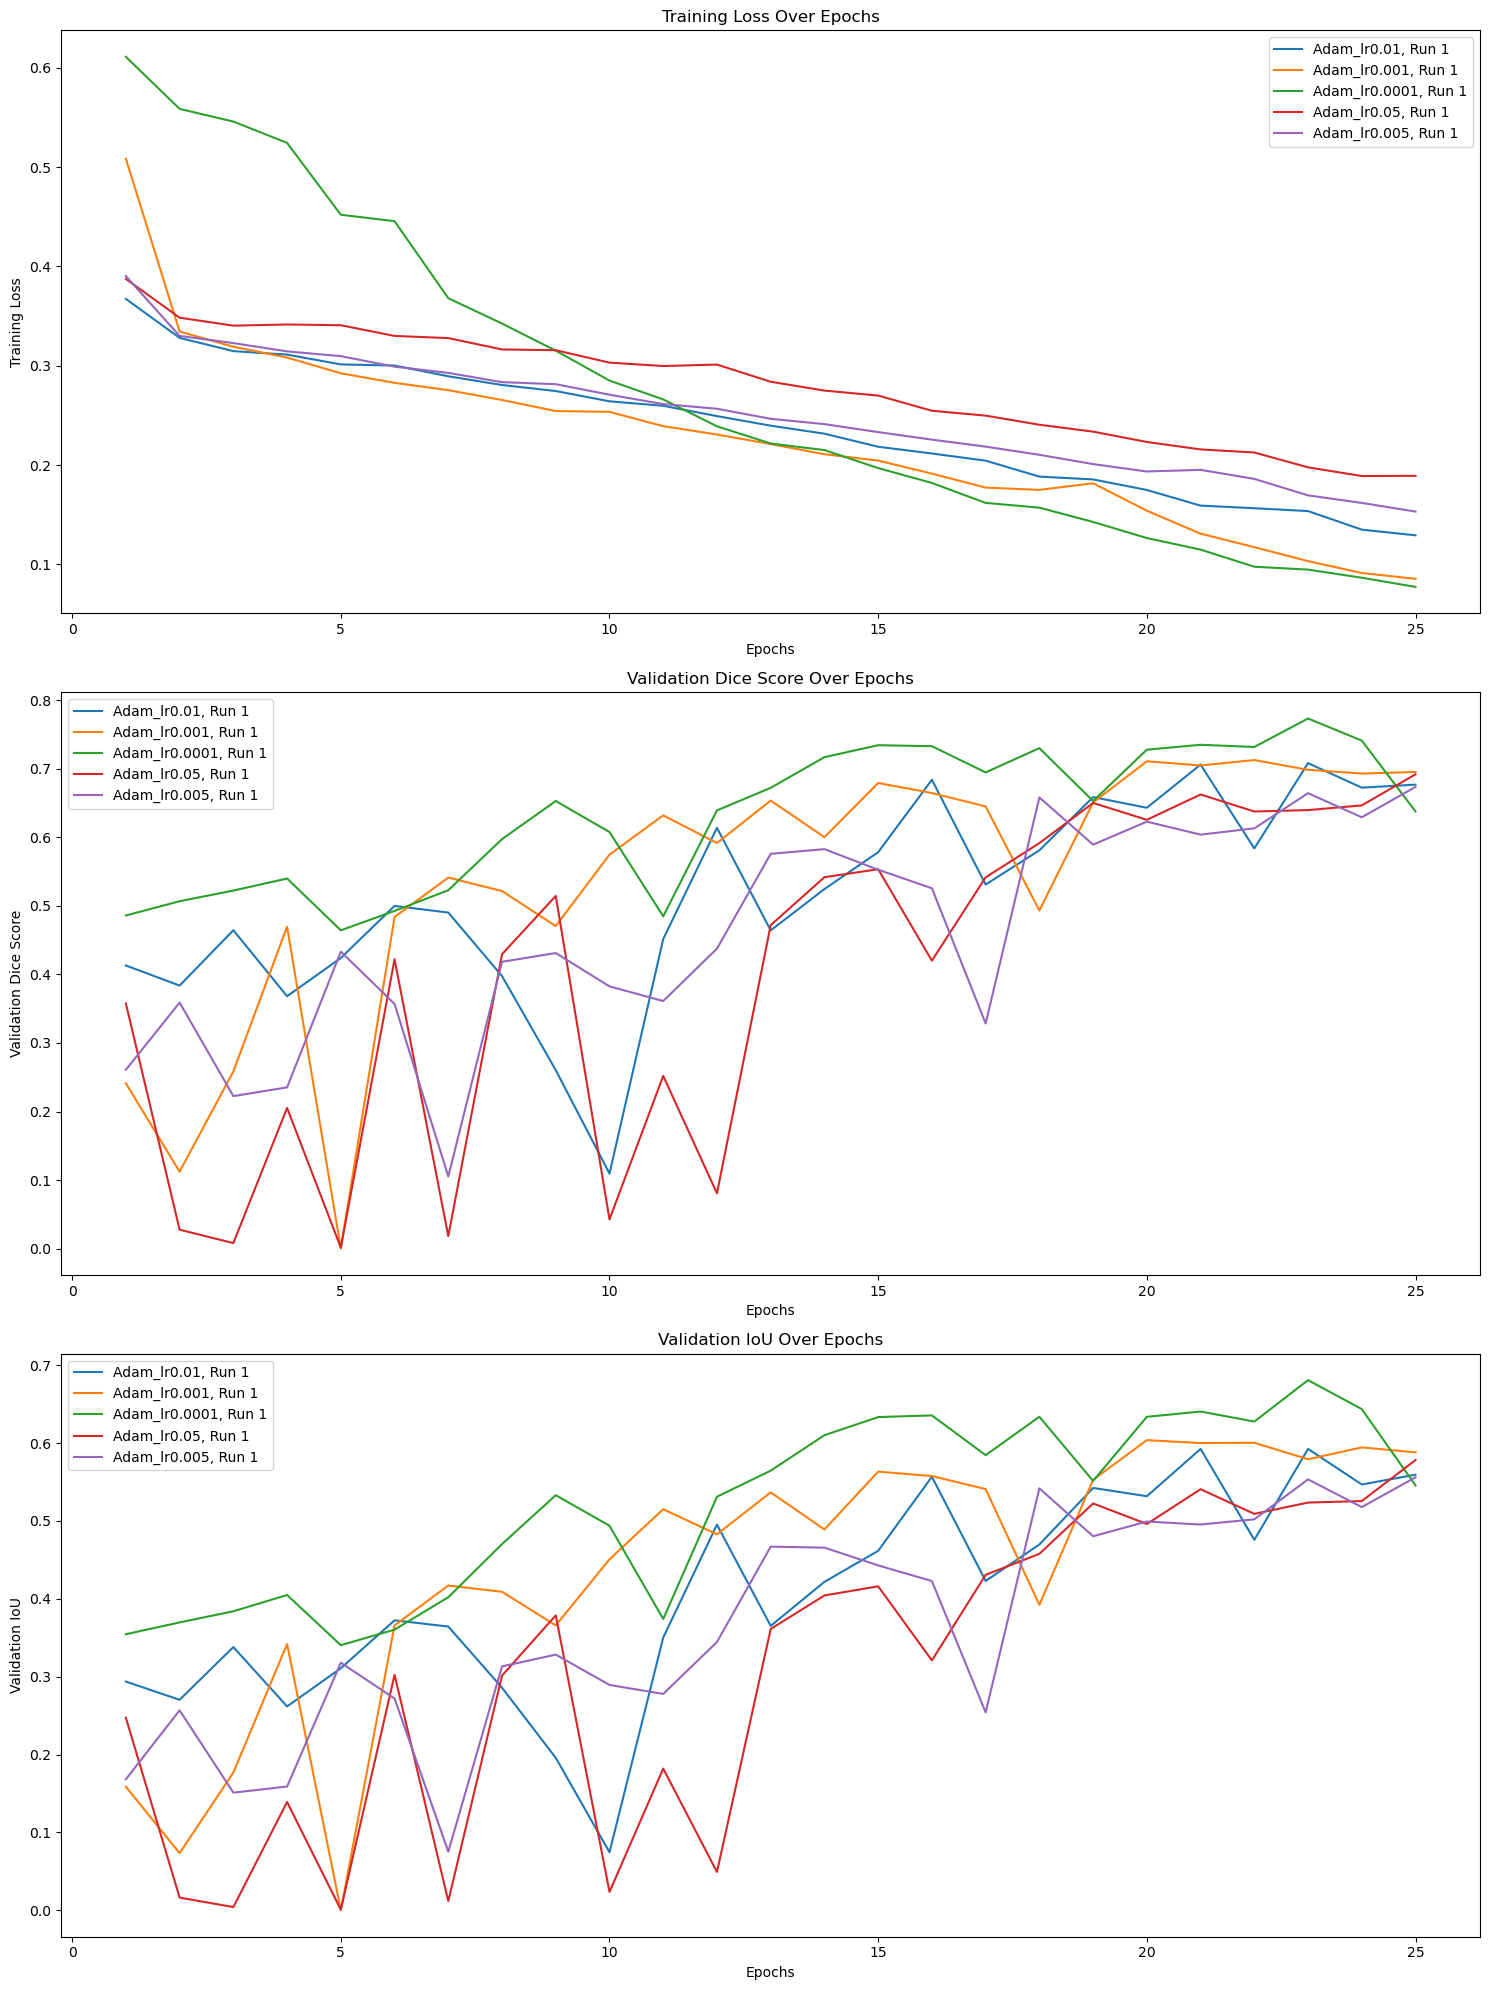

In [67]:
plot_lr_results(all_results, num_epochs=25)